This code is used to create plots for ice thickness and snow depth validation products. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import chain
from mpl_toolkits.basemap import Basemap
#import cartopy.crs as ccrs
#import cartopy
import netCDF4 as nc 
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import pickle


In [2]:
save_fig = 0

## Fonctions for the analysis

In [ ]:
def draw_map(m, scale=0.2):
    # draw a shaded-relief image
    # m.shadedrelief(scale=scale)
    m.drawlsmask(land_color='gray',ocean_color='white',lakes=True)
    # lats and longs are returned as a dictionary
    lats = m.drawparallels(np.linspace(-90, 90, 13))
    lons = m.drawmeridians(np.linspace(-180, 180, 13))

    # keys contain the plt.Line2D instances
    lat_lines = chain(*(tup[1][0] for tup in lats.items()))
    lon_lines = chain(*(tup[1][0] for tup in lons.items()))
    all_lines = chain(lat_lines, lon_lines)
    
    # cycle through these lines and set the desired style
    for line in all_lines:
        line.set(linestyle='-', alpha=0.3, color='w')

def mask_observations(observations, inversion):
    new_inversion = np.copy(inversion)
    for i in range(len(observations)):
        for j in range(len(observations[0])):
            if np.isnan(observations[i][j]):
                new_inversion[i][j] = np.nan
    return new_inversion


def mask_high_error(stddev, inversion):
    new_inversion = np.copy(inversion)
    for i in range(len(stddev)):
        for j in range(len(stddev[0])):
            if stddev[i][j] >= inversion[i][j]*(30/100):
                new_inversion[i][j] = np.nan
    return new_inversion

def mask_sie(sie_map, inversion):
    new_inversion = np.copy(inversion)
    for i in range(len(sie_map)):
        for j in range(len(sie_map[0])):
            if not np.isnan(sie_map[i][j]) and sie_map[i][j] < 0.7:
                new_inversion[i][j] = np.nan
    return new_inversion


def pearson(inverse, OIB):
    # pearson coefficient
    ydata = np.array(inverse)
    yfit = np.array(OIB)

    ydata_mean = np.mean(ydata)
    yfit_mean = np.mean(yfit)

    data_diff = ydata - ydata_mean
    fit_diff = yfit - yfit_mean

    top = np.sum( (data_diff) * (fit_diff) )

    bottom = np.sqrt( np.sum(data_diff**2) * np.sum(fit_diff**2) )

    r = top/bottom

    return r

def analyse (calculated_data, validation_data):
    error = np.array(calculated_data) - np.array(validation_data)
    md = np.mean(error)
    rmse = np.sqrt( np.mean( (error)**2 ))
    residuals = error**2
    denom = (calculated_data - np.mean(calculated_data)) ** 2
    r2 = 1 - (np.sum(residuals) / np.sum(denom))

    # Calculate slope and y-intercept
    slope, intercept = np.polyfit(validation_data, calculated_data, 1)

    return md, rmse, r2, slope, intercept


In [ ]:
def filter_data(oib_file, oib_snow, snow_file, snow, lon, lat, is2_file, cs_file, Hi_data, Hs_data):
    ''' filters out the data that is available in both OIB and inversion files'''
    #loading OIB data
    #OIB = nc.Dataset('/home/erb/masterproject/MSCI_project/OIB/25km_ease_binned_data/20190415.nc')
    OIB  = nc.Dataset(oib_file)
    SD   = OIB.variables['Snow Depth'][:,:]
    long = OIB.variables['Longitude'][:,:]
    lati = OIB.variables['Latitude'][:,:]

    # loading inversion and freeboard data
    is2 = np.load(is2_file)
    cs  = np.load(cs_file)
    inverse_snow = np.load(snow_file)
    inverse_snow = mask_observations(is2, inverse_snow) # mask the observations to actual Altika tracks

    # forward linear regression
    DENSITY_WATER = 997.0
    DENSITY_ICE = 917.0
    DENSITY_SNOW = 300.0
    SPEED_OF_LIGHT_VACUUM_OVER_SPEED_OF_LIGHT_SNOW = 1.28

    A = (DENSITY_WATER - DENSITY_ICE) / DENSITY_WATER
    B = 1 - SPEED_OF_LIGHT_VACUUM_OVER_SPEED_OF_LIGHT_SNOW -DENSITY_SNOW/DENSITY_WATER
    D = 1 - DENSITY_SNOW/DENSITY_WATER

    Hi = (D*cs - B*is2)/ A*(D-B)
    Hs = (cs - is2) / (B -D)


    for i in range(360):
        for j in range(360):
            if not (SD.mask[i][j]) and not np.isnan(inverse_snow[i][j]):
                    #print(SD.data[i][j])
                oib_snow.append(SD.data[i][j])
                snow.append(inverse_snow[i][j])
                lon.append(long.data[i][j])
                lat.append(lati.data[i][j])
                Hi_data.append(Hi[i][j])
                Hs_data.append(Hs[i][j])

    OIB.close() 

In [ ]:
import os

def extract_dates(folder_path):
    date = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.npy_snow') and not filename.endswith('.npy_ice_stddev'):
            info = filename.split('_')[4].split('.')[0] #split by '_' and remove .npy
            date.append(info)
    date.sort()
    return date

def extract_files(folder_path, dates, type):
    matching_files = []
    for date in dates:
        year = int(date[:4])  # Extract the year from the date
        initial_year = f"{year-1}-{year}"
        filename = f"FB_interp_{initial_year}_25km_{date}{type}"
        #filename = f"tesselationVoronoi_initcell10_iteration100000_date{date}{type}"
        file_path = os.path.join(folder_path, filename)
        #if os.path.exists(file_path):
        matching_files.append(file_path)
    return matching_files

def extract_IS2_files(folder_path, dates, type):
    matching_files = []
    for date in dates:
        year = int(date[:4])  # Extract the year from the date
        filename = f"FB_interp_{year}_25km_{date}{type}"
        #filename = f"tesselationVoronoi_initcell10_iteration100000_date{date}{type}"
        file_path = os.path.join(folder_path, filename)
        #if os.path.exists(file_path):
        matching_files.append(file_path)
    return matching_files

def extract_snow_files(folder_path, dates, type):
    matching_files = []
    for date in dates:
        year = int(date[:4])  # Extract the year from the date
        #filename = f"FB_interp_{year}_25km_{date}{type}"
        filename = f"tesselationDelaunay_initcell1000_iteration700000_date{date}_window+4j_snow{type}"
        file_path = os.path.join(folder_path, filename)
        #if os.path.exists(file_path):
        matching_files.append(file_path)
    return matching_files

def extract_OIB(folder_path, dates):
    files = []
    for date in dates:
        filename = f'{date}.nc'
        file_path = os.path.join(folder_path, filename)

        #if os.path.exists(file_path):
        files.append(file_path)

    return files


In [ ]:
import os


def extract_files(folder_path, dates, type):
    matching_files = []
    for date in dates:
        year = int(date[:4])  # Extract the year from the date
        initial_year = f"{2019}-{2020}"
        filename = f"FB_interp_{initial_year}_25km_{date}{type}"
        file_path = os.path.join(folder_path, filename)
        #if os.path.exists(file_path):
        matching_files.append(file_path)
    return matching_files

## Validation for snow

In [ ]:
# MOSAIC Validation data (Winter 2019 - 2020)

date = ['20191115', '20191215', '20200115', '20200215', '20200315', '20200415']

snow_files = extract_snow_files('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/', date, '.npy')
MOSAIC_files = extract_OIB('/home/erb/masterproject/MSCI_project/validation_data/various_data/UIT_MOSAIC', date)
is2_files = extract_IS2_files('/home/erb/masterproject/MSCI_project/snow_ice/carmen/daily_numpys/IS2/', date,'.npy')
cs_files = extract_files('/home/erb/masterproject/MSCI_project/snow_ice/carmen/daily_numpys/CS2_LARM/', date, '.npy')

In [ ]:
# Initialize arrays to store filtered data
MOSAIC_snow = []
lon_data = []
lat_data = []
snow_data = []
Hi_data = []
Hs_data = []

for i in range(len(date)):
    filter_data(MOSAIC_files[i], MOSAIC_snow, snow_files[i], snow_data, lon_data, lat_data, is2_files[i], cs_files[i], Hi_data, Hs_data)

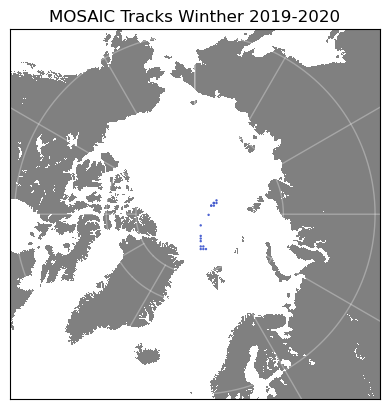

In [ ]:
plt.figure()
m = Basemap(projection='lcc', resolution=None, lat_0=-90, lon_0=0, lat_1=89.9, lon_1=180, width=0.7E7, height=0.7E7)
draw_map(m)
plt.title('MOSAIC Tracks Winther 2019-2020')
m.scatter(lon_data, lat_data, latlon=True, alpha=1, s=0.5, c=MOSAIC_snow, cmap="coolwarm", vmin=0, vmax=6)
plt.show()

year = '2019-2020'

if save_fig == 1 :
    plt.savefig('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/validation/MOSAiC_tracks' + year + '.png')


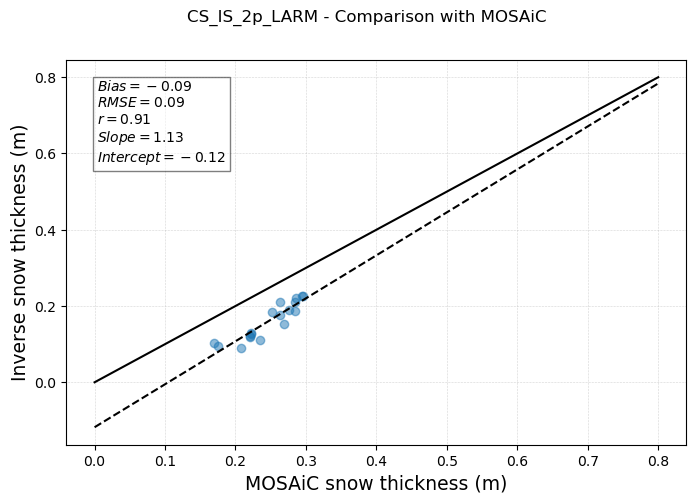

In [ ]:
fig = plt.figure(figsize=(8, 5))


plt.suptitle('CS_IS_2p_LARM - Comparison with MOSAiC')
#ax = fig.add_subplot(121)

plt.scatter(MOSAIC_snow, snow_data, alpha = 0.5)
plt.plot([0,0.8] , [0,0.8], 'k-')
plt.grid(linestyle='dotted', linewidth ='0.4')
plt.xlabel('MOSAiC snow thickness (m)', fontsize = 13.5)
plt.ylabel('Inverse snow thickness (m)', fontsize = 13.5)
#ax.set_title("Agreement plot for inverse snow model")

md_snow_inverse, rmse_snow_inverse, r2_snow_inverse, slope, intercept = analyse(snow_data, MOSAIC_snow)
r_snow = pearson(MOSAIC_snow, snow_data)

textstr = '\n'.join((
    rf'$Bias={md_snow_inverse:.2f}$',
    rf'$RMSE={rmse_snow_inverse:.2f}$',
    #rf'$R^2={r2_snow_inverse:.2f}$',
    rf'$r = {r_snow:.2f}$',
    rf'$Slope = {slope:.2f}$',
    rf'$Intercept = {intercept:.2f}$'))
box_props = dict(boxstyle='square', facecolor= 'white', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=box_props)

# Regression line
x_values = np.array([0,0.8])
y_values = slope * x_values + intercept
plt.plot(x_values, y_values, 'k--')



if save_fig == 1 :
    plt.savefig('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/validation/non_interpolated/validation_MOSAiC' + year + '.png')


In [ ]:
import os

def extract_snow_files(folder_path, dates, type):
    matching_files = []
    for date in dates:
        year = int(date[:4])  # Extract the year from the date
        #filename = f"FB_interp_{year}_25km_{date}{type}"
        filename = f"tesselationDelaunay_initcell1000_iteration700000_date{date}_window+-2j_error0.01_snow{type}"
        file_path = os.path.join(folder_path, filename)
        #if os.path.exists(file_path):
        matching_files.append(file_path)
    return matching_files

def extract_files(folder_path, dates, type):
    matching_files = []
    for date in dates:
        year = int(date[:4])  # Extract the year from the date
        initial_year = f"{2018}-{2019}"
        filename = f"FB_interp_{initial_year}_25km_{date}{type}"
        file_path = os.path.join(folder_path, filename)
        #if os.path.exists(file_path):
        matching_files.append(file_path)
    return matching_files

In [ ]:
# IceBird Validation data 

date = ['20190415']

snow_files = extract_snow_files('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/', date, '.npy')
IB_files = extract_OIB('/home/erb/masterproject/MSCI_project/validation_data/various_data/UIT_IB', date)
is2_files = extract_IS2_files('/home/erb/masterproject/MSCI_project/snow_ice/carmen/daily_numpys/IS2/', date,'.npy')
cs_files = extract_files('/home/erb/masterproject/MSCI_project/snow_ice/carmen/daily_numpys/CS2_LARM/', date, '.npy')

In [ ]:
# Initialize arrays to store filtered data
IB_snow = []
lon_data = []
lat_data = []
snow_data = []
Hi_data = []
Hs_data = []

for i in range(len(date)):
    filter_data(IB_files[i], IB_snow, snow_files[i], snow_data, lon_data, lat_data, is2_files[i], cs_files[i], Hi_data, Hs_data)

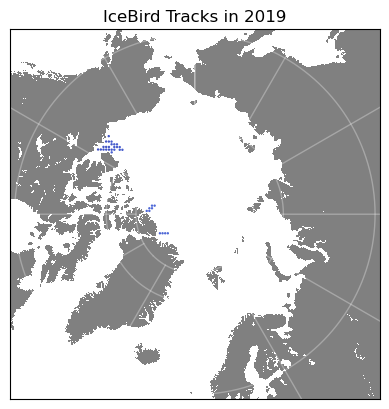

In [ ]:
plt.figure()
m = Basemap(projection='lcc', resolution=None, lat_0=-90, lon_0=0, lat_1=89.9, lon_1=180, width=0.7E7, height=0.7E7)
draw_map(m)
plt.title('IceBird Tracks in 2019')
m.scatter(lon_data, lat_data, latlon=True, alpha=1, s=0.5, c=IB_snow, cmap="coolwarm", vmin=0, vmax=6)
plt.show()

year = '04-2019'

if save_fig == 1 :
    plt.savefig('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/validation/IceBird_tracks' + year + '.png')



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


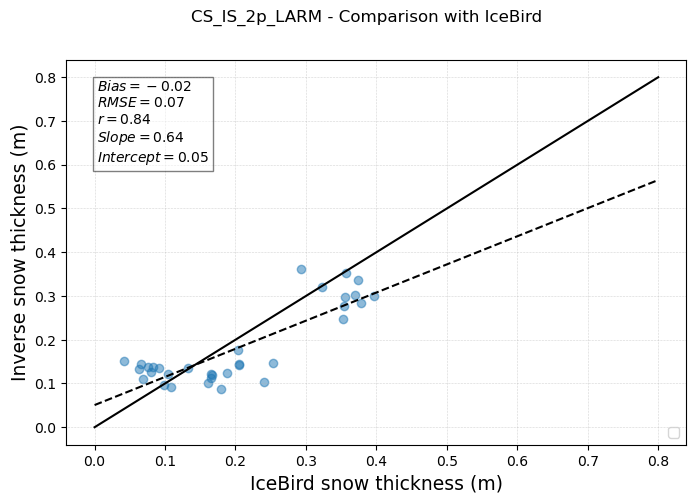

In [ ]:
fig = plt.figure(figsize = (8,5))
plt.suptitle('CS_IS_2p_LARM - Comparison with IceBird')

#ax = fig.add_subplot(121)
plt.scatter(IB_snow, snow_data, alpha = 0.5)
plt.plot([0,0.8] , [0,0.8], 'k-')
plt.grid(linestyle='dotted', linewidth ='0.4')
plt.xlabel('IceBird snow thickness (m)', fontsize = 13.5)
plt.ylabel('Inverse snow thickness (m)', fontsize = 13.5)
#ax.set_title("Agreement plot for inverse snow model")

md_snow_inverse, rmse_snow_inverse, r2_snow_inverse, slope, intercept = analyse(snow_data, IB_snow)
r_snow = pearson(IB_snow, snow_data)

textstr = '\n'.join((
    rf'$Bias={md_snow_inverse:.2f}$',
    rf'$RMSE={rmse_snow_inverse:.2f}$',
    #rf'$R^2={r2_snow_inverse:.2f}$',
    rf'$r = {r_snow:.2f}$',
    rf'$Slope = {slope:.2f}$',
    rf'$Intercept = {intercept:.2f}$'))
box_props = dict(boxstyle='square', facecolor= 'white', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=box_props)

# Regression line
x_values = np.array([0,0.8])
y_values = slope * x_values + intercept
plt.plot(x_values, y_values, 'k--')

plt.legend(loc = 'lower right')



if save_fig == 1 :
    plt.savefig('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/validation/non_interpolated/validation_IceBird' + year + '.png')



In [ ]:
# OIB Validation data 

date = ['20190415']

snow_files = extract_snow_files('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/', date, '.npy')
OIB_files = extract_OIB('/home/erb/masterproject/MSCI_project/validation_data/UIT_OIB', date)
is2_files = extract_IS2_files('/home/erb/masterproject/MSCI_project/snow_ice/carmen/daily_numpys/IS2/', date,'.npy')
cs_files = extract_files('/home/erb/masterproject/MSCI_project/snow_ice/carmen/daily_numpys/CS2_LARM/', date, '.npy')

In [ ]:
# Initialize arrays to store filtered data
OIB_snow = []
lon_data = []
lat_data = []
snow_data = []
Hi_data = []
Hs_data = []

for i in range(len(date)):
    filter_data(OIB_files[i], OIB_snow, snow_files[i], snow_data, lon_data, lat_data, is2_files[i], cs_files[i], Hi_data, Hs_data)

KeyboardInterrupt: 

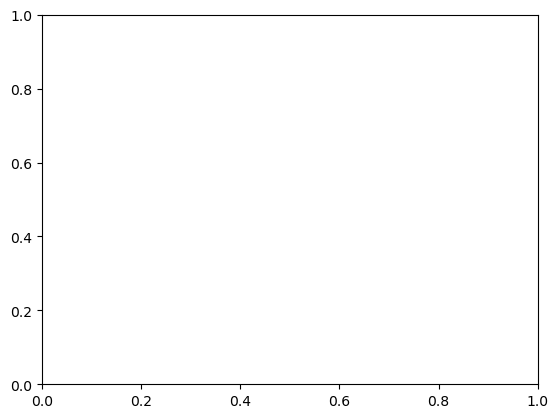

In [ ]:
plt.figure()
m = Basemap(projection='lcc', resolution=None, lat_0=-90, lon_0=0, lat_1=89.9, lon_1=180, width=0.7E7, height=0.7E7)
draw_map(m)
plt.title('OIB Tracks in 2019')
m.scatter(lon_data, lat_data, latlon=True, alpha=1, s=0.5, c=OIB_snow, cmap="coolwarm", vmin=0, vmax=6)
plt.show()

year = '04-2019'

if save_fig == 1 :
    plt.savefig('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/validation/OIB_tracks' + year + '.png')



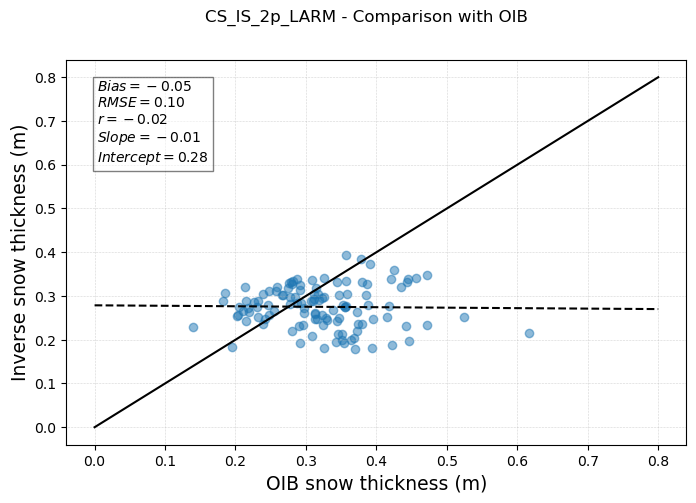

In [ ]:
fig = plt.figure(figsize = (8, 5))
plt.suptitle('CS_IS_2p_LARM - Comparison with OIB')

#ax = fig.add_subplot(121)
plt.scatter(OIB_snow, snow_data, alpha = 0.5)
plt.plot([0,0.8] , [0,0.8], 'k-')
plt.grid(linestyle='dotted', linewidth ='0.4')
plt.xlabel('OIB snow thickness (m)', fontsize = 13.5)
plt.ylabel('Inverse snow thickness (m)', fontsize = 13.5)
#ax.set_title("Agreement plot for inverse snow model")

md_snow_inverse, rmse_snow_inverse, r2_snow_inverse, slope, intercept = analyse(snow_data, OIB_snow)
r_snow = pearson(OIB_snow, snow_data)

textstr = '\n'.join((
    rf'$Bias={md_snow_inverse:.2f}$',
    rf'$RMSE={rmse_snow_inverse:.2f}$',
    #rf'$R^2={r2_snow_inverse:.2f}$',
    rf'$r = {r_snow:.2f}$',
    rf'$Slope = {slope:.2f}$',
    rf'$Intercept = {intercept:.2f}$'))
box_props = dict(boxstyle='square', facecolor= 'white', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=box_props)

# Regression line
x_values = np.array([0,0.8])
y_values = slope * x_values + intercept
plt.plot(x_values, y_values, 'k--')


if save_fig == 1 :
    plt.savefig('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/validation/non_interpolated/validation_OIB' + year + '.png')




In [3]:
test = nc.Dataset('/home/erb/masterproject/MSCI_project/validation_data/OIB_data/174828816/RDEFT4_20200127.nc')

In [4]:
test.variables.keys()

dict_keys(['sea_ice_thickness', 'snow_depth', 'snow_density', 'lat', 'lon', 'freeboard', 'roughness', 'ice_con'])

In [ ]:
snow_file = nc.Dataset("/home/erb/masterproject/MSCI_project/validation_data/various_data/SMLG_snod_EASE.nc")
snow_11 = snow_file.variables['Snow Depth'][3607, :, :]
snow_12 = snow_file.variables['Snow Depth'][3636, :, :]
snow_01 = snow_file.variables['Snow Depth'][3667, :, :]
snow_02 = snow_file.variables['Snow Depth'][3697, :, :]
snow_03 = snow_file.variables['Snow Depth'][3727, :, :]
snow_04 = snow_file.variables['Snow Depth'][3758, :, :]
snow_file.close()
snow_lg = [snow_11,snow_12,snow_01,snow_02,snow_03,snow_04]


In [ ]:
is_files = ["/home/erb/masterproject/MSCI_project/snow_ice/carmen/daily_numpys/IS2/FB_interp_2019_25km_20191115.npy",
      "/home/erb/masterproject/MSCI_project/snow_ice/carmen/daily_numpys/IS2/FB_interp_2019_25km_20191215.npy",
      "/home/erb/masterproject/MSCI_project/snow_ice/carmen/daily_numpys/IS2/FB_interp_2020_25km_20200115.npy",
      "/home/erb/masterproject/MSCI_project/snow_ice/carmen/daily_numpys/IS2/FB_interp_2020_25km_20200215.npy",
      "/home/erb/masterproject/MSCI_project/snow_ice/carmen/daily_numpys/IS2/FB_interp_2020_25km_20200315.npy",
      "/home/erb/masterproject/MSCI_project/snow_ice/carmen/daily_numpys/IS2/FB_interp_2020_25km_20200415.npy"]

cs_files = ["/home/erb/masterproject/MSCI_project/snow_ice/carmen/daily_numpys/CS2_LARM/FB_interp_2019-2020_25km_20191115.npy",
      "/home/erb/masterproject/MSCI_project/snow_ice/carmen/daily_numpys/CS2_LARM/FB_interp_2019-2020_25km_20191215.npy",
      "/home/erb/masterproject/MSCI_project/snow_ice/carmen/daily_numpys/CS2_LARM/FB_interp_2019-2020_25km_20200115.npy",
      "/home/erb/masterproject/MSCI_project/snow_ice/carmen/daily_numpys/CS2_LARM/FB_interp_2019-2020_25km_20200215.npy",
      "/home/erb/masterproject/MSCI_project/snow_ice/carmen/daily_numpys/CS2_LARM/FB_interp_2019-2020_25km_20200315.npy",
       "/home/erb/masterproject/MSCI_project/snow_ice/carmen/daily_numpys/CS2_LARM/FB_interp_2019-2020_25km_20200415.npy"]

inverse_snow_files = ['/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201911/15tesselationDelaunay_initcell800_iteration3000000_date_window5j_error0.01_snow.npy',
                        '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201912/15tesselationDelaunay_initcell800_iteration3000000_date_window5j_error0.01_snow.npy',
                        '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/202001/15tesselationDelaunay_initcell800_iteration3000000_date_window5j_error0.01_snow.npy',
                        '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/202002/15tesselationDelaunay_initcell800_iteration3000000_date_window5j_error0.01_snow.npy',
                        '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/202003/15tesselationDelaunay_initcell800_iteration3000000_date_window5j_error0.01_snow.npy',
                        '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/202004/15tesselationDelaunay_initcell800_iteration3000000_date_window5j_error0.01_snow.npy']

inverse_snow_stddev = ['/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201911/15tesselationDelaunay_initcell800_iteration3000000_window5j_error0.01_snow_stddev.npy',
                        '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201912/15tesselationDelaunay_initcell800_iteration3000000_window5j_error0.01_snow_stddev.npy',
                        '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/202001/15tesselationDelaunay_initcell800_iteration3000000_window5j_error0.01_snow_stddev.npy',
                        '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/202002/15tesselationDelaunay_initcell800_iteration3000000_window5j_error0.01_snow_stddev.npy',
                        '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/202003/15tesselationDelaunay_initcell800_iteration3000000_window5j_error0.01_snow_stddev.npy',
                        '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/202004/15tesselationDelaunay_initcell800_iteration3000000_window5j_error0.01_snow_stddev.npy']


awismos_snow_files = ['/home/erb/masterproject/MSCI_project/validation_data/awismos/data_awismos_l3c_month/2019/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-201911-fv2p4.nc',
                      '/home/erb/masterproject/MSCI_project/validation_data/awismos/data_awismos_l3c_month/2019/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-201912-fv2p4.nc',
                      '/home/erb/masterproject/MSCI_project/validation_data/awismos/data_awismos_l3c_month/2020/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-202001-fv2p4.nc',
                      '/home/erb/masterproject/MSCI_project/validation_data/awismos/data_awismos_l3c_month/2020/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-202002-fv2p4.nc',
                      '/home/erb/masterproject/MSCI_project/validation_data/awismos/data_awismos_l3c_month/2020/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-202003-fv2p4.nc',
                      '/home/erb/masterproject/MSCI_project/validation_data/awismos/data_awismos_l3c_month/2020/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-202004-fv2p4.nc']

sie_path = '/home/erb/masterproject/MSCI_project/snow_ice/carmen/SIE/SIE_masking_25km_2019-2020_season.pkl'
f = open(sie_path,'rb')
sie_file = pickle.load(f)
sie_map  = [sie_file['20191115'], sie_file['20191215'], sie_file['20200115'], sie_file['20200215'], sie_file['20200315'], sie_file['20200415']]

# grids
lon_g = np.load("/home/erb/masterproject/MSCI_project/new_lon_25km.npy")
lat_g = np.load("/home/erb/masterproject/MSCI_project/new_lat_25km.npy")

In [ ]:
sd_awi_11 = nc.Dataset(awismos_snow_files[0]).variables['snow_depth'][0][36:396,36:396][::-1, :]
sd_awi_12 = nc.Dataset(awismos_snow_files[1]).variables['snow_depth'][0][36:396,36:396][::-1, :]
sd_awi_01 = nc.Dataset(awismos_snow_files[2]).variables['snow_depth'][0][36:396,36:396][::-1, :]
sd_awi_02 = nc.Dataset(awismos_snow_files[3]).variables['snow_depth'][0][36:396,36:396][::-1, :]
sd_awi_03 = nc.Dataset(awismos_snow_files[4]).variables['snow_depth'][0][36:396,36:396][::-1, :]
sd_awi_04 = nc.Dataset(awismos_snow_files[5]).variables['snow_depth'][0][36:396,36:396][::-1, :]

snow_awi = [sd_awi_11, sd_awi_12, sd_awi_01, sd_awi_02, sd_awi_03, sd_awi_04]


/tmp/ipykernel_379731/497692377.py:1: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  sd_awi_11 = nc.Dataset(awismos_snow_files[0]).variables['snow_depth'][0][36:396,36:396][::-1, :]
/tmp/ipykernel_379731/497692377.py:1: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type
  sd_awi_11 = nc.Dataset(awismos_snow_files[0]).variables['snow_depth'][0][36:396,36:396][::-1, :]
/tmp/ipykernel_379731/497692377.py:2: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  sd_awi_12 = nc.Dataset(awismos_snow_files[1]).variables['snow_depth'][0][36:396,36:396][::-1, :]
/tmp/ipykernel_379731/497692377.py:2: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type
  sd_awi_12 = nc.Dataset(awismos_snow_files[1]).variables['snow_depth'][0][36:396,36:396][::-1, :]
/tmp/ipykernel_379731/497692377.py:3: UserWarning: WARNING: valid_min not us

In [ ]:
snow_inverse =[]
snow_compare = []
snow_awismos = []
snow_compare_awismos = []

DENSITY_WATER = 997.0
DENSITY_ICE = 917.0
DENSITY_SNOW = 300.0
SPEED_OF_LIGHT_VACUUM_OVER_SPEED_OF_LIGHT_SNOW = 1.28

for i in range(5):
    
    A = (DENSITY_WATER - DENSITY_ICE) / DENSITY_WATER
    B = 1 - SPEED_OF_LIGHT_VACUUM_OVER_SPEED_OF_LIGHT_SNOW -DENSITY_SNOW/DENSITY_WATER
    D = 1 - DENSITY_SNOW/DENSITY_WATER

    Hi = (A*np.load(cs_files[i]) - B*np.load(is_files[i]))/ A*(D-B)
    Hs = (np.load(cs_files[i]) - np.load(is_files[i])) / (B -D)

    snow_inverse_data = np.load(inverse_snow_files[i])
    snow_inverse_stddev = np.load(inverse_snow_stddev[i])
    snow_inverse_data = mask_observations(Hi,snow_inverse_data)
    snow_inverse_data = mask_high_error(snow_inverse_stddev,snow_inverse_data)
    snow_inverse_data = mask_sie(sie_map[i], snow_inverse_data)

    for k in range(360):
        for j in range(360):
            if not (snow_lg[i].mask[k][j]) and not np.isnan(snow_inverse_data[k][j]):
                snow_inverse.append(snow_inverse_data[k][j])
                snow_compare.append(snow_lg[i].data[k][j])
                
    for k in range(360):
        for j in range(360):
            if not (snow_lg[i].mask[k][j]) and not np.isnan(snow_awi[i][k][j]):
                snow_compare_awismos.append(snow_lg[i].data[k][j])
                snow_awismos.append(snow_awi[i][k][j])


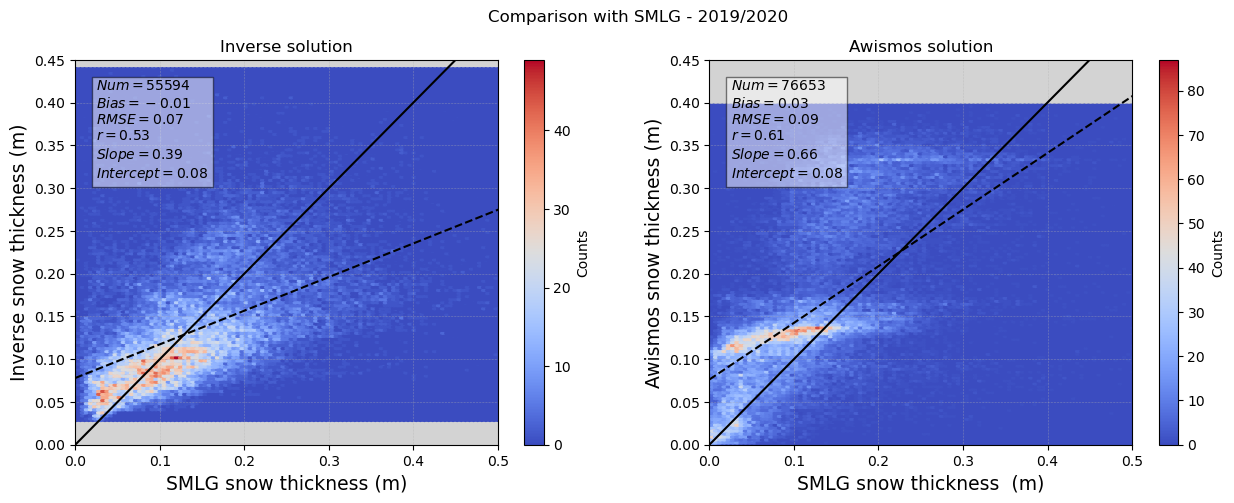

In [ ]:
fig = plt.figure(figsize=(15, 5))
plt.suptitle('Comparison with SMLG - 2019/2020')

plt.subplot(121)
plt.title('Inverse solution')
#plt.scatter(snow_compare, snow_inverse, alpha = 0.5)
plt.hexbin(snow_compare, snow_inverse, gridsize=200, cmap='coolwarm')
plt.plot([0,0.8] , [0,0.8], 'k-')
plt.ylim(0, 0.45)
plt.xlim(0, 0.5)
plt.colorbar(label='Counts')
plt.grid(linestyle='dotted', linewidth ='0.4')
plt.xlabel('SMLG snow thickness (m)', fontsize = 13.5)
plt.ylabel('Inverse snow thickness (m)', fontsize = 13.5)

ax = plt.gca()
ax.set_facecolor('lightgrey')

md_snow_inverse, rmse_snow_inverse, r2_snow_inverse, slope, intercept = analyse(snow_inverse, snow_compare)
r_snow = pearson(snow_compare, snow_inverse)

textstr = '\n'.join((
    rf'$Num = {len(snow_inverse)}$',
    rf'$Bias={md_snow_inverse:.2f}$',
    rf'$RMSE={rmse_snow_inverse:.2f}$',
    #rf'$R^2={r2_snow_inverse:.2f}$',
    rf'$r = {r_snow:.2f}$',
    rf'$Slope = {slope:.2f}$',
    rf'$Intercept = {intercept:.2f}$'
    ))
box_props = dict(boxstyle='square', facecolor= 'white', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=box_props)

# Regression line
x_values = np.array([0,0.8])
y_values = slope * x_values + intercept
plt.plot(x_values, y_values, 'k--', label='Linear Regression')


plt.subplot(122)
plt.title('Awismos solution')
#plt.scatter(snow_compare, snow_inverse, alpha = 0.5)
plt.hexbin(snow_compare_awismos, snow_awismos, gridsize=200, cmap='coolwarm')
plt.plot([0,0.8] , [0,0.8], 'k-')
plt.ylim(0, 0.45)
plt.xlim(0, 0.5)
plt.colorbar(label='Counts')
plt.grid(linestyle='dotted', linewidth ='0.4')
plt.xlabel('SMLG snow thickness  (m)', fontsize = 13.5)
plt.ylabel('Awismos snow thickness (m)', fontsize = 13.5)

ax = plt.gca()
ax.set_facecolor('lightgrey')

md_snow_inverse, rmse_snow_inverse, r2_snow_inverse, slope, intercept = analyse(snow_awismos, snow_compare_awismos)
r_snow = pearson(snow_compare_awismos, snow_awismos)

textstr = '\n'.join((
    rf'$Num = {len(snow_awismos)}$',
    rf'$Bias={md_snow_inverse:.2f}$',
    rf'$RMSE={rmse_snow_inverse:.2f}$',
    #rf'$R^2={r2_snow_inverse:.2f}$',
    rf'$r = {r_snow:.2f}$',
    rf'$Slope = {slope:.2f}$',
    rf'$Intercept = {intercept:.2f}$'
    ))
box_props = dict(boxstyle='square', facecolor= 'white', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=box_props)

# Regression line
x_values = np.array([0,0.8])
y_values = slope * x_values + intercept
plt.plot(x_values, y_values, 'k--', label='Linear Regression')




year = '2019-2020'

if save_fig == 1 :
    plt.savefig('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/validation/non_interpolated/validation_SMLG' + year + '.png')



## Validation for ice 

In [ ]:
icebird_file = ['/home/erb/masterproject/MSCI_project/validation_data/IceBird_data/binned_data_Icebird/20190407.nc',
                '/home/erb/masterproject/MSCI_project/validation_data/IceBird_data/binned_data_Icebird/20190408.nc',
                '/home/erb/masterproject/MSCI_project/validation_data/IceBird_data/binned_data_Icebird/20190410.nc']

awismos_file = ['/home/erb/masterproject/MSCI_project/validation_data/awismos/data_awismos_l3c_month/2019/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-201904-fv2p4.nc']

awismos = nc.Dataset(awismos_file[0])
awismos.variables.keys()
SIT_awismos = awismos.variables['sea_ice_thickness'][0][36:396,36:396][::-1, :]

In [ ]:
def ice_icebird(icebird_file):

    SIT_icebird = nc.Dataset(icebird_file).variables['sea_ice_thickness'][:,:]
    return SIT_icebird

In [ ]:
test = nc.Dataset(icebird_file[1])
test.variables.keys()

dict_keys(['sea_ice_thickness', 'snow_depth', 'longitude', 'latitude'])

In [ ]:
SIT_icebird = []
ice_inverse = []


for i in range(len(icebird_file)):
    
    file_icebird = ice_icebird(icebird_file[i])
    inverse_ice_data = np.load('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201904/15tesselationDelaunay_initcell800_iteration3000000_date_window5j_error0.01_ice.npy')
    inverse_ice_stddev = np.load('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201904/15tesselationDelaunay_initcell800_iteration3000000_window5j_error0.01_ice_stddev.npy')
    inverse_ice_data = mask_high_error(inverse_ice_stddev, inverse_ice_data)
    for k in range(360):
        for j in range(360):
            if not (file_icebird.mask[k][j]) and not np.isnan(inverse_ice_data[k][j]):
                ice_inverse.append(inverse_ice_data[k][j])
                SIT_icebird.append(file_icebird[k][j])


SIT_icebird_2 = []
ice_awismos = []


for i in range(len(icebird_file)):
    
    file_icebird = ice_icebird(icebird_file[i])

    for k in range(360):
        for j in range(360):
            if not (file_icebird.mask[k][j]) and not np.isnan(SIT_awismos[k][j]):
                ice_awismos.append(SIT_awismos[k][j])
                SIT_icebird_2.append(file_icebird[k][j])


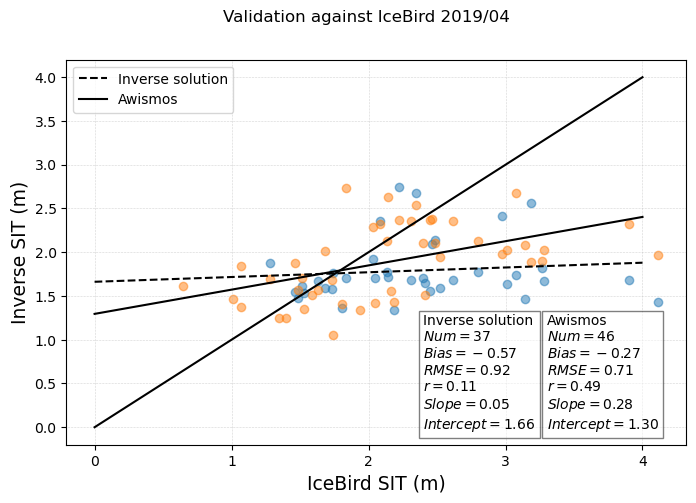

In [ ]:
fig = plt.figure(figsize = (8, 5))
plt.suptitle('Validation against IceBird 2019/04')

plt.scatter(SIT_icebird, ice_inverse, alpha = 0.5)
plt.scatter(SIT_icebird_2, ice_awismos, alpha = 0.5)
plt.grid(linestyle='dotted', linewidth ='0.4')
plt.xlabel('IceBird SIT (m)', fontsize = 13.5)
plt.ylabel('Inverse SIT (m)', fontsize = 13.5)
plt.plot([0,4] , [0,4], 'k-')

md_ice_inverse, rmse_ice_inverse, r2_ice_inverse, slope, intercept = analyse(ice_inverse, SIT_icebird)
r_ice = pearson(SIT_icebird, ice_inverse)

textstr = '\n'.join((
    rf'Inverse solution',
    rf'$Num = {len(ice_inverse)}$',
    rf'$Bias={md_ice_inverse:.2f}$',
    rf'$RMSE={rmse_ice_inverse:.2f}$',
    #rf'$R^2={r2_snow_inverse:.2f}$',
    rf'$r = {r_ice:.2f}$',
    rf'$Slope = {slope:.2f}$',
    rf'$Intercept = {intercept:.2f}$'))
box_props = dict(boxstyle='square', facecolor= 'white', alpha=0.5)
plt.text(2.4, 1.3, textstr, bbox=box_props, verticalalignment='top')

x_values = np.array([0,4])
y_values = slope * x_values + intercept
plt.plot(x_values, y_values, 'k--', label = "Inverse solution")

md_ice_inverse, rmse_ice_inverse, r2_ice_inverse, slope, intercept = analyse(ice_awismos, SIT_icebird_2)
r_ice = pearson(SIT_icebird_2, ice_awismos)

textstr = '\n'.join((
    rf'Awismos',
    rf'$Num = {len(ice_awismos)}$',
    rf'$Bias={md_ice_inverse:.2f}$',
    rf'$RMSE={rmse_ice_inverse:.2f}$',
    #rf'$R^2={r2_snow_inverse:.2f}$',
    rf'$r = {r_ice:.2f}$',
    rf'$Slope = {slope:.2f}$',
    rf'$Intercept = {intercept:.2f}$'))
box_props = dict(boxstyle='square', facecolor= 'white', alpha=0.5)
plt.text(3.3, 1.3, textstr, bbox=box_props, verticalalignment='top')

x_values = np.array([0,4])
y_values = slope * x_values + intercept
plt.plot(x_values, y_values, 'k', label ="Awismos")

plt.legend(loc= 'upper left')

In [ ]:
BGEP_file_ULSA = nc.Dataset('/home/erb/masterproject/MSCI_project/validation_data/BGEP_data/BGEP_data/ULS_A/SMLG_ERA5_SIT_EASE_01Jan2010-30Apr2021.nc')
BGEP_file_ULSB = nc.Dataset('/home/erb/masterproject/MSCI_project/validation_data/BGEP_data/BGEP_data/ULS_B/SMLG_ERA5_SIT_EASE_01Jan2010-30Apr2021.nc')
BGEP_file_ULSD = nc.Dataset('/home/erb/masterproject/MSCI_project/validation_data/BGEP_data/BGEP_data/ULS_D/SMLG_ERA5_SIT_EASE_01Jan2010-30Apr2021.nc')
BGEP_file_ULSA.variables.keys()

dict_keys(['Sea Ice Thickness', 'Latitude', 'Longitude', 'Day'])

In [ ]:
BGEP_SIT_ULSA   = BGEP_file_ULSA.variables['Sea Ice Thickness'][:]
BGEP_SIT_ULSB   = BGEP_file_ULSB.variables['Sea Ice Thickness'][:]
BGEP_SIT_ULSD   = BGEP_file_ULSD.variables['Sea Ice Thickness'][:]

BGEP_lon_ULSA   = BGEP_file_ULSA.variables['Longitude'][:]
BGEP_lat_ULSA   = BGEP_file_ULSA.variables['Latitude'][:]
BGEP_days_ULSA  = BGEP_file_ULSA.variables['Day'][:]

In [ ]:
lon_g[234][134]

-140.14276455788425

In [ ]:
lat_g[234][134]

74.05366814580078

In [ ]:
inverse_ice_files = ["/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20181103_window+-2j_error0.1_ice.npy",
                     "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20181115_window+-2j_error0.1_ice.npy",
                     "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20181127_window+-2j_error0.1_ice.npy",
                     "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20181203_window+-2j_error0.1_ice.npy",
                     "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20181215_window+-2j_error0.1_ice.npy",
                     "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20181227_window+-2j_error0.1_ice.npy",
                     "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20190103_window+-2j_error0.1_ice.npy",
                     "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20190115_window+-2j_error0.1_ice.npy",
                     "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20190127_window+-2j_error0.1_ice.npy",
                     "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20190215_window+-2j_error0.1_ice.npy",
                     "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20190225_window+-2j_error0.1_ice.npy",
                     "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20190303_window+-2j_error0.1_ice.npy",
                     "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20190315_window+-2j_error0.1_ice.npy",
                     "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20190327_window+-2j_error0.1_ice.npy",
                     "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20190403_window+-2j_error0.1_ice.npy",
                     "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20190415_window+-2j_error0.1_ice.npy"]


def inverse_ice(inverse_ice_files, lon, lat):

    inverse_ice = []

    for i in range(len(inverse_ice_files)):
        inverse_ice.append(np.load(inverse_ice_files[i])[lon][lat])

    return inverse_ice


In [ ]:
date = [3228, 3240, 3252, 3258, 3270, 3282, 3289, 3301, 3313, 3332, 3342, 3348, 3360, 3372, 3379, 3391]


def BGEP_ice(BGEP_file, date):
    BGEP_SIT = []
    for i in range(len(date)):
        BGEP_SIT.append(BGEP_file[date[i]])
    return BGEP_SIT


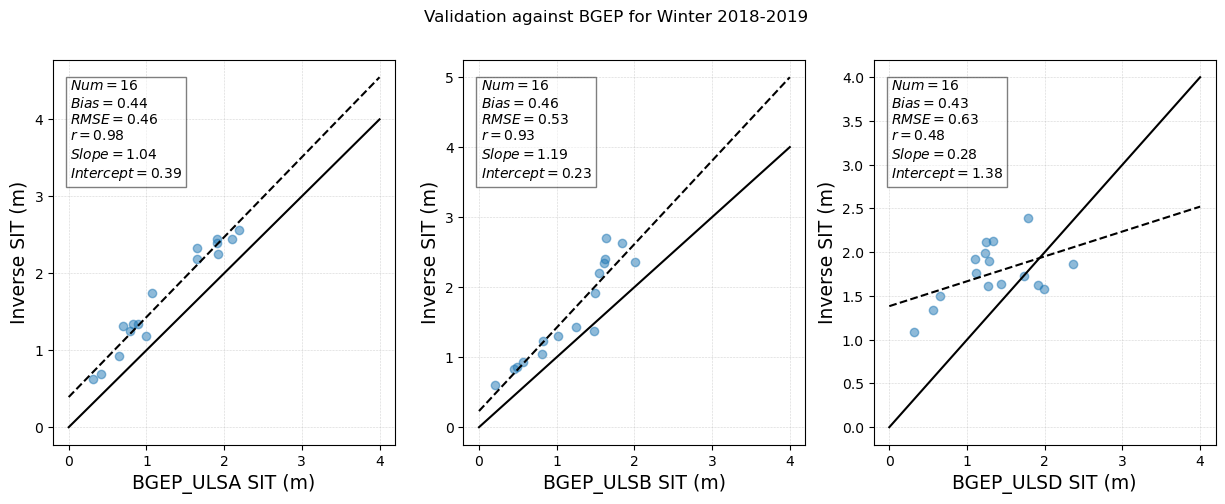

In [ ]:
fig = plt.figure(figsize = (15, 5))
plt.suptitle('Validation against BGEP for Winter 2018-2019')

plt.subplot(131)

plt.scatter(BGEP_ice(BGEP_SIT_ULSA, date), inverse_ice(inverse_ice_files, 235, 148), alpha = 0.5)
plt.grid(linestyle='dotted', linewidth ='0.4')
plt.xlabel('BGEP_ULSA SIT (m)', fontsize = 13.5)
plt.ylabel('Inverse SIT (m)', fontsize = 13.5)
plt.plot([0,4] , [0,4], 'k-')

md_ice_inverse, rmse_ice_inverse, r2_ice_inverse, slope, intercept = analyse(inverse_ice(inverse_ice_files, 235, 148), BGEP_ice(BGEP_SIT_ULSA, date))
r_ice = pearson(BGEP_ice(BGEP_SIT_ULSA, date), inverse_ice(inverse_ice_files, 235, 148))

textstr = '\n'.join((
    rf'$Num = {len(inverse_ice(inverse_ice_files, 235, 148))}$',
    rf'$Bias={md_ice_inverse:.2f}$',
    rf'$RMSE={rmse_ice_inverse:.2f}$',
    #rf'$R^2={r2_snow_inverse:.2f}$',
    rf'$r = {r_ice:.2f}$',
    rf'$Slope = {slope:.2f}$',
    rf'$Intercept = {intercept:.2f}$'))
box_props = dict(boxstyle='square', facecolor= 'white', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=box_props)

x_values = np.array([0,4])
y_values = slope * x_values + intercept
plt.plot(x_values, y_values, 'k--')

plt.subplot(132)
plt.scatter(BGEP_ice(BGEP_SIT_ULSB, date), inverse_ice(inverse_ice_files, 225, 153), alpha = 0.5)
plt.grid(linestyle='dotted', linewidth ='0.4')
plt.xlabel('BGEP_ULSB SIT (m)', fontsize = 13.5)
plt.ylabel('Inverse SIT (m)', fontsize = 13.5)
plt.plot([0,4] , [0,4], 'k-')

md_ice_inverse, rmse_ice_inverse, r2_ice_inverse, slope, intercept = analyse(inverse_ice(inverse_ice_files, 225, 153), BGEP_ice(BGEP_SIT_ULSB, date))
r_ice = pearson(BGEP_ice(BGEP_SIT_ULSB, date), inverse_ice(inverse_ice_files, 225, 153))

textstr = '\n'.join((
    rf'$Num = {len(inverse_ice(inverse_ice_files, 225, 153))}$',
    rf'$Bias={md_ice_inverse:.2f}$',
    rf'$RMSE={rmse_ice_inverse:.2f}$',
    #rf'$R^2={r2_snow_inverse:.2f}$',
    rf'$r = {r_ice:.2f}$',
    rf'$Slope = {slope:.2f}$',
    rf'$Intercept = {intercept:.2f}$'))
box_props = dict(boxstyle='square', facecolor= 'white', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=box_props)

x_values = np.array([0,4])
y_values = slope * x_values + intercept
plt.plot(x_values, y_values, 'k--')

plt.subplot(133)
plt.scatter(BGEP_ice(BGEP_SIT_ULSD, date), inverse_ice(inverse_ice_files, 234, 134), alpha = 0.5)
plt.grid(linestyle='dotted', linewidth ='0.4')
plt.xlabel('BGEP_ULSD SIT (m)', fontsize = 13.5)
plt.ylabel('Inverse SIT (m)', fontsize = 13.5)
plt.plot([0,4] , [0,4], 'k-')

md_ice_inverse, rmse_ice_inverse, r2_ice_inverse, slope, intercept = analyse(inverse_ice(inverse_ice_files, 234, 134), BGEP_ice(BGEP_SIT_ULSD, date))
r_ice = pearson(BGEP_ice(BGEP_SIT_ULSD, date), inverse_ice(inverse_ice_files, 234, 134))

textstr = '\n'.join((
    rf'$Num = {len(inverse_ice(inverse_ice_files, 234, 134))}$',
    rf'$Bias={md_ice_inverse:.2f}$',
    rf'$RMSE={rmse_ice_inverse:.2f}$',
    #rf'$R^2={r2_snow_inverse:.2f}$',
    rf'$r = {r_ice:.2f}$',
    rf'$Slope = {slope:.2f}$',
    rf'$Intercept = {intercept:.2f}$'))
box_props = dict(boxstyle='square', facecolor= 'white', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=box_props)

x_values = np.array([0,4])
y_values = slope * x_values + intercept
plt.plot(x_values, y_values, 'k--')




In [ ]:
OIB_files = ["/home/erb/masterproject/MSCI_project/validation_data/OIB_data/OIB_201904/20190408.nc",
             "/home/erb/masterproject/MSCI_project/validation_data/OIB_data/OIB_201904/20190412.nc",
             "/home/erb/masterproject/MSCI_project/validation_data/OIB_data/OIB_201904/20190419.nc",
             "/home/erb/masterproject/MSCI_project/validation_data/OIB_data/OIB_201904/20190420.nc",
             "/home/erb/masterproject/MSCI_project/validation_data/OIB_data/OIB_201904/20190422.nc"]

inverse_ice = ['/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201904/15tesselationDelaunay_initcell800_iteration3000000_date_window5j_error0.01_ice.npy']

awismos_file = ['/home/erb/masterproject/MSCI_project/validation_data/awismos/data_awismos_l3c_month/2019/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-201904-fv2p4.nc']


lon_g = np.load("/home/erb/masterproject/MSCI_project/new_lon_25km.npy")
lat_g = np.load("/home/erb/masterproject/MSCI_project/new_lat_25km.npy")


In [ ]:
awismos = nc.Dataset(awismos_file[0])
awismos.variables.keys()
SIT_awismos = awismos.variables['sea_ice_thickness'][0][36:396,36:396][::-1, :]

In [ ]:
def ice_OIB(OIB_files):

    SIT_OIB = nc.Dataset(OIB_files).variables['Sea Ice Thickness'][:,:]
    return SIT_OIB

In [ ]:
SIT_OIB, SIT_OIB_2 = [], []
ice_inverse = []
ice_awismos = []


for i in range(len(OIB_files)):
    
    file_OIB = ice_OIB(OIB_files[i])
    inverse_ice_data = np.load('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201904/15tesselationDelaunay_initcell800_iteration3000000_date_window5j_error0.01_ice.npy')

    for k in range(360):
        for j in range(360):
            if not (file_OIB.mask[k][j]) and not np.isnan(inverse_ice_data[k][j]):
                ice_inverse.append(inverse_ice_data[k][j])
                SIT_OIB.append(file_OIB[k][j])


for i in range(len(OIB_files)):
    
    file_OIB = ice_OIB(OIB_files[i])

    for k in range(360):
        for j in range(360):
            if not (file_OIB.mask[k][j]) and not np.isnan(SIT_awismos[k][j]):
                ice_awismos.append(SIT_awismos[k][j])
                SIT_OIB_2.append(file_OIB[k][j])

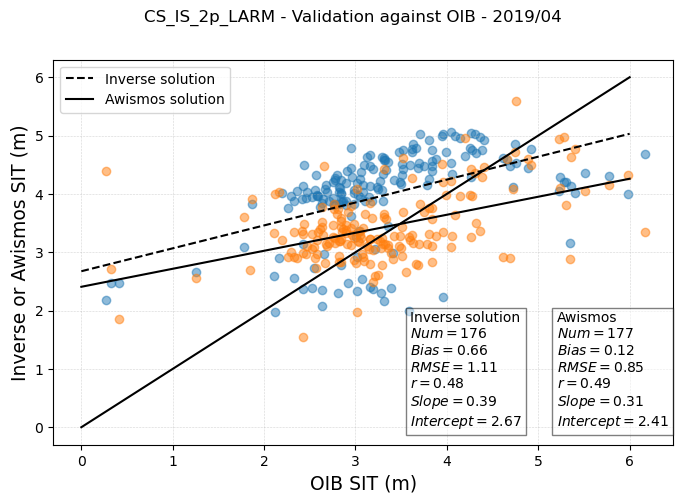

In [ ]:
fig = plt.figure(figsize = (8, 5))
plt.suptitle('CS_IS_2p_LARM - Validation against OIB - 2019/04')

#ax = fig.add_subplot(121)
plt.scatter(SIT_OIB, ice_inverse, alpha = 0.5)
plt.scatter(SIT_OIB_2, ice_awismos, alpha = 0.5)
plt.plot([0,6] , [0,6], 'k-')
plt.grid(linestyle='dotted', linewidth ='0.4')
plt.xlabel('OIB SIT (m)', fontsize = 13.5)
plt.ylabel('Inverse or Awismos SIT (m)', fontsize = 13.5)
#ax.set_title("Agreement plot for inverse snow model")

md_snow_inverse, rmse_snow_inverse, r2_snow_inverse, slope, intercept = analyse(ice_inverse, SIT_OIB)
r_snow = pearson(SIT_OIB, ice_inverse)

textstr = '\n'.join((
    rf'Inverse solution',
    rf'$Num = {len(ice_inverse)}$',
    rf'$Bias={md_snow_inverse:.2f}$',
    rf'$RMSE={rmse_snow_inverse:.2f}$',
    rf'$r = {r_snow:.2f}$',
    rf'$Slope = {slope:.2f}$',
    rf'$Intercept = {intercept:.2f}$'))
box_props = dict(boxstyle='square', facecolor= 'white', alpha=0.5)
plt.text(3.6, 2, textstr, bbox=box_props, verticalalignment='top')

x_values = np.array([0,6])
y_values = slope * x_values + intercept
plt.plot(x_values, y_values, 'k--', label = 'Inverse solution')


md_snow_inverse, rmse_snow_inverse, r2_snow_inverse, slope, intercept = analyse(ice_awismos, SIT_OIB_2)
r_snow = pearson(SIT_OIB_2, ice_awismos)

textstr = '\n'.join((
    rf'Awismos',
    rf'$Num = {len(ice_awismos)}$',
    rf'$Bias={md_snow_inverse:.2f}$',
    rf'$RMSE={rmse_snow_inverse:.2f}$',
    rf'$r = {r_snow:.2f}$',
    rf'$Slope = {slope:.2f}$',
    rf'$Intercept = {intercept:.2f}$'))
box_props = dict(boxstyle='square', facecolor= 'white', alpha=0.5)
plt.text(5.2, 2, textstr, bbox=box_props, verticalalignment='top')

# Regression line
x_values = np.array([0,6])
y_values = slope * x_values + intercept
plt.plot(x_values, y_values, 'k', label = "Awismos solution")

plt.legend(loc = "upper left")





In [ ]:
sumata_f11 = ['/home/erb/masterproject/MSCI_project/validation_data/SUMATA_data/binned_data/F11_201811_SMLG_ERA5_EASE.nc',
            '/home/erb/masterproject/MSCI_project/validation_data/SUMATA_data/binned_data/F11_201812_SMLG_ERA5_EASE.nc',
            '/home/erb/masterproject/MSCI_project/validation_data/SUMATA_data/binned_data/F11_201901_SMLG_ERA5_EASE.nc',
            '/home/erb/masterproject/MSCI_project/validation_data/SUMATA_data/binned_data/F11_201902_SMLG_ERA5_EASE.nc',
            '/home/erb/masterproject/MSCI_project/validation_data/SUMATA_data/binned_data/F11_201903_SMLG_ERA5_EASE.nc',
            '/home/erb/masterproject/MSCI_project/validation_data/SUMATA_data/binned_data/F11_201904_SMLG_ERA5_EASE.nc']

sumata_f12 = ['/home/erb/masterproject/MSCI_project/validation_data/SUMATA_data/binned_data/F12_201811_SMLG_ERA5_EASE.nc',
            '/home/erb/masterproject/MSCI_project/validation_data/SUMATA_data/binned_data/F12_201812_SMLG_ERA5_EASE.nc',
            '/home/erb/masterproject/MSCI_project/validation_data/SUMATA_data/binned_data/F12_201901_SMLG_ERA5_EASE.nc',
            '/home/erb/masterproject/MSCI_project/validation_data/SUMATA_data/binned_data/F12_201902_SMLG_ERA5_EASE.nc',
            '/home/erb/masterproject/MSCI_project/validation_data/SUMATA_data/binned_data/F12_201903_SMLG_ERA5_EASE.nc',
            '/home/erb/masterproject/MSCI_project/validation_data/SUMATA_data/binned_data/F12_201904_SMLG_ERA5_EASE.nc']

sumata_f13 = ['/home/erb/masterproject/MSCI_project/validation_data/SUMATA_data/binned_data/F13_201811_SMLG_ERA5_EASE.nc',
            '/home/erb/masterproject/MSCI_project/validation_data/SUMATA_data/binned_data/F13_201812_SMLG_ERA5_EASE.nc',
            '/home/erb/masterproject/MSCI_project/validation_data/SUMATA_data/binned_data/F13_201901_SMLG_ERA5_EASE.nc',
            '/home/erb/masterproject/MSCI_project/validation_data/SUMATA_data/binned_data/F13_201902_SMLG_ERA5_EASE.nc',
            '/home/erb/masterproject/MSCI_project/validation_data/SUMATA_data/binned_data/F13_201903_SMLG_ERA5_EASE.nc',
            '/home/erb/masterproject/MSCI_project/validation_data/SUMATA_data/binned_data/F13_201904_SMLG_ERA5_EASE.nc']

sumata_f14 = ['/home/erb/masterproject/MSCI_project/validation_data/SUMATA_data/binned_data/F14_201811_SMLG_ERA5_EASE.nc',
            '/home/erb/masterproject/MSCI_project/validation_data/SUMATA_data/binned_data/F14_201812_SMLG_ERA5_EASE.nc',
            '/home/erb/masterproject/MSCI_project/validation_data/SUMATA_data/binned_data/F14_201901_SMLG_ERA5_EASE.nc',
            '/home/erb/masterproject/MSCI_project/validation_data/SUMATA_data/binned_data/F14_201902_SMLG_ERA5_EASE.nc',
            '/home/erb/masterproject/MSCI_project/validation_data/SUMATA_data/binned_data/F14_201903_SMLG_ERA5_EASE.nc',
            '/home/erb/masterproject/MSCI_project/validation_data/SUMATA_data/binned_data/F14_201904_SMLG_ERA5_EASE.nc']

sumata_ice_f11, sumata_ice_f12, sumata_ice_f13, sumata_ice_f14 = [], [], [], []
lon_f11, lat_f11, lon_f12, lat_f12, lon_f13, lat_f13, lon_f14, lat_f14 = [], [], [], [], [], [], [], []

for i in range(len(sumata_f11)):
    sumata_ice_f11.append(nc.Dataset(sumata_f11[i]).variables['sea_ice_thickness'][:])
    sumata_ice_f12.append(nc.Dataset(sumata_f12[i]).variables['sea_ice_thickness'][:])
    sumata_ice_f13.append(nc.Dataset(sumata_f13[i]).variables['sea_ice_thickness'][:])
    sumata_ice_f14.append(nc.Dataset(sumata_f14[i]).variables['sea_ice_thickness'][:])

    lon_f11.append(nc.Dataset(sumata_f11[i]).variables['ease_lon'][:])
    lat_f11.append(nc.Dataset(sumata_f11[i]).variables['ease_lat'][:])

    lon_f12.append(nc.Dataset(sumata_f12[i]).variables['ease_lon'][:])
    lat_f12.append(nc.Dataset(sumata_f12[i]).variables['ease_lat'][:])

    lon_f13.append(nc.Dataset(sumata_f13[i]).variables['ease_lon'][:])
    lat_f13.append(nc.Dataset(sumata_f13[i]).variables['ease_lat'][:])
        
    lon_f14.append(nc.Dataset(sumata_f14[i]).variables['ease_lon'][:])
    lat_f14.append(nc.Dataset(sumata_f14[i]).variables['ease_lat'][:])

In [ ]:
inverse_ice_file = ["/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201811/15tesselationDelaunay_initcell1000_iteration1000000_date_window5j_error0.01_ice.npy",
                    '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201812/15tesselationDelaunay_initcell1000_iteration1000000_date_window5j_error0.01_ice.npy',
                    '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201901/15tesselationDelaunay_initcell1000_iteration1000000_date_window5j_error0.01_ice.npy',
                    '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201902/15tesselationDelaunay_initcell1000_iteration1000000_date_window5j_error0.01_ice.npy',
                    '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201903/15tesselationDelaunay_initcell1000_iteration1000000_date_window5j_error0.01_ice.npy',
                    '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201904/15tesselationDelaunay_initcell1000_iteration1000000_date_window5j_error0.01_ice.npy']

def inverse_ice(inverse_ice_file):
    ice_inverse = []
    for i in range(len(inverse_ice_file)):
        ice_inverse.append(np.load(inverse_ice_file[i]))

    return ice_inverse

In [ ]:
ice_inverse = inverse_ice(inverse_ice_file)

ice_inverse[0].shape

(360, 360)

In [ ]:
ice_inverse_f11, ice_inverse_f12, ice_inverse_f13, ice_inverse_f14 = [], [], [], []

for i in range(len(ice_inverse)):
    ice_inverse_f11.append(ice_inverse[i][229][182])
    ice_inverse_f12.append(ice_inverse[i][229][182])
    ice_inverse_f13.append(ice_inverse[i][228][183])
    ice_inverse_f14.append(ice_inverse[i][228][185])

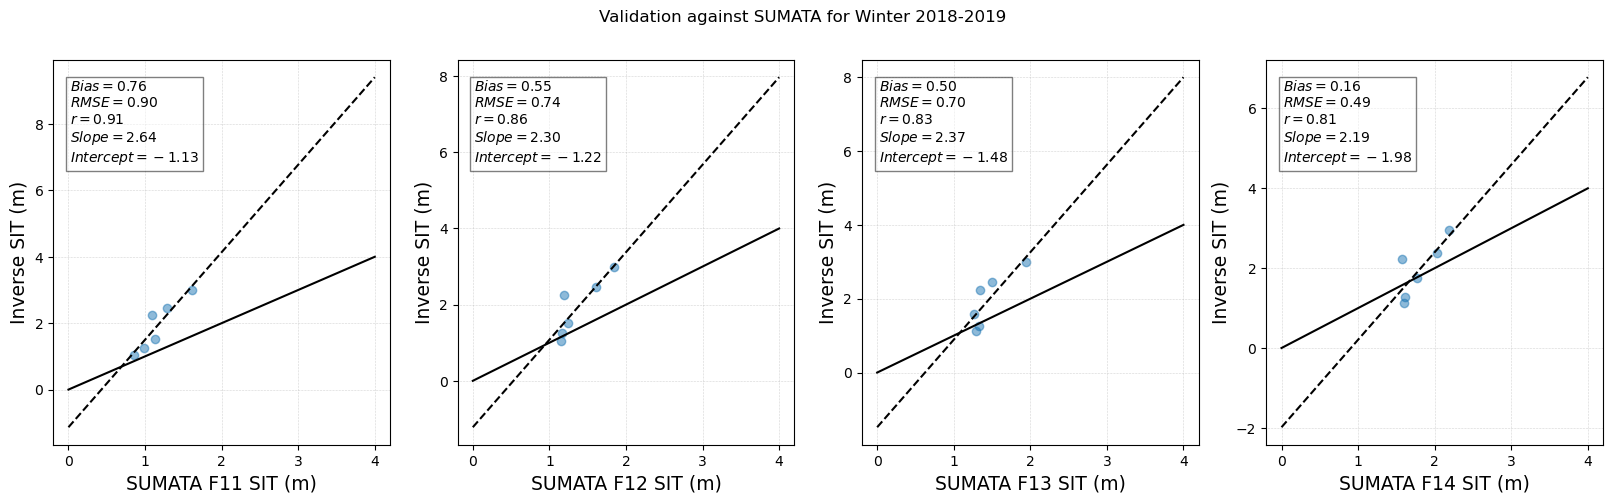

In [ ]:
fig = plt.figure(figsize = (20, 5))
plt.suptitle('Validation against SUMATA for Winter 2018-2019')

plt.subplot(141)

plt.scatter(sumata_ice_f11, ice_inverse_f11, alpha = 0.5)
plt.grid(linestyle='dotted', linewidth ='0.4')
plt.xlabel('SUMATA F11 SIT (m)', fontsize = 13.5)
plt.ylabel('Inverse SIT (m)', fontsize = 13.5)
plt.plot([0,4] , [0,4], 'k-')

md_ice_inverse, rmse_ice_inverse, r2_ice_inverse, slope, intercept = analyse(ice_inverse_f11, sumata_ice_f11)
r_ice = pearson(sumata_ice_f11, ice_inverse_f11)

textstr = '\n'.join((
    rf'$Bias={md_ice_inverse:.2f}$',
    rf'$RMSE={rmse_ice_inverse:.2f}$',
    #rf'$R^2={r2_snow_inverse:.2f}$',
    rf'$r = {r_ice:.2f}$',
    rf'$Slope = {slope:.2f}$',
    rf'$Intercept = {intercept:.2f}$'))
box_props = dict(boxstyle='square', facecolor= 'white', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=box_props)

x_values = np.array([0,4])
y_values = slope * x_values + intercept
plt.plot(x_values, y_values, 'k--')

plt.subplot(142)
plt.scatter(sumata_ice_f12, ice_inverse_f12, alpha = 0.5)
plt.grid(linestyle='dotted', linewidth ='0.4')
plt.xlabel('SUMATA F12 SIT (m)', fontsize = 13.5)
plt.ylabel('Inverse SIT (m)', fontsize = 13.5)
plt.plot([0,4] , [0,4], 'k-')

md_ice_inverse, rmse_ice_inverse, r2_ice_inverse, slope, intercept = analyse(ice_inverse_f12, sumata_ice_f12)
r_ice = pearson(sumata_ice_f12, ice_inverse_f12)

textstr = '\n'.join((
    rf'$Bias={md_ice_inverse:.2f}$',
    rf'$RMSE={rmse_ice_inverse:.2f}$',
    #rf'$R^2={r2_snow_inverse:.2f}$',
    rf'$r = {r_ice:.2f}$',
    rf'$Slope = {slope:.2f}$',
    rf'$Intercept = {intercept:.2f}$'))
box_props = dict(boxstyle='square', facecolor= 'white', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=box_props)

x_values = np.array([0,4])
y_values = slope * x_values + intercept
plt.plot(x_values, y_values, 'k--')

plt.subplot(143)
plt.scatter(sumata_ice_f13, ice_inverse_f13, alpha = 0.5)
plt.grid(linestyle='dotted', linewidth ='0.4')
plt.xlabel('SUMATA F13 SIT (m)', fontsize = 13.5)
plt.ylabel('Inverse SIT (m)', fontsize = 13.5)
plt.plot([0,4] , [0,4], 'k-')

md_ice_inverse, rmse_ice_inverse, r2_ice_inverse, slope, intercept = analyse(ice_inverse_f13, sumata_ice_f13)
r_ice = pearson(sumata_ice_f13, ice_inverse_f13)

textstr = '\n'.join((
    rf'$Bias={md_ice_inverse:.2f}$',
    rf'$RMSE={rmse_ice_inverse:.2f}$',
    #rf'$R^2={r2_snow_inverse:.2f}$',
    rf'$r = {r_ice:.2f}$',
    rf'$Slope = {slope:.2f}$',
    rf'$Intercept = {intercept:.2f}$'))
box_props = dict(boxstyle='square', facecolor= 'white', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=box_props)

x_values = np.array([0,4])
y_values = slope * x_values + intercept
plt.plot(x_values, y_values, 'k--')

plt.subplot(144)
plt.scatter(sumata_ice_f14, ice_inverse_f14, alpha = 0.5)
plt.grid(linestyle='dotted', linewidth ='0.4')
plt.xlabel('SUMATA F14 SIT (m)', fontsize = 13.5)
plt.ylabel('Inverse SIT (m)', fontsize = 13.5)
plt.plot([0,4] , [0,4], 'k-')

md_ice_inverse, rmse_ice_inverse, r2_ice_inverse, slope, intercept = analyse(ice_inverse_f14, sumata_ice_f14)
r_ice = pearson(sumata_ice_f14, ice_inverse_f14)

textstr = '\n'.join((
    rf'$Bias={md_ice_inverse:.2f}$',
    rf'$RMSE={rmse_ice_inverse:.2f}$',
    #rf'$R^2={r2_snow_inverse:.2f}$',
    rf'$r = {r_ice:.2f}$',
    rf'$Slope = {slope:.2f}$',
    rf'$Intercept = {intercept:.2f}$'))
box_props = dict(boxstyle='square', facecolor= 'white', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=box_props)

x_values = np.array([0,4])
y_values = slope * x_values + intercept
plt.plot(x_values, y_values, 'k--')

In [ ]:
# File for AWISMOS over the winter 2018-2019

path_awismos = ['/home/erb/masterproject/MSCI_project/validation_data/awismos/data_awismos_l3c_month/2018/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-201811-fv2p4.nc',
                '/home/erb/masterproject/MSCI_project/validation_data/awismos/data_awismos_l3c_month/2018/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-201812-fv2p4.nc',
                '/home/erb/masterproject/MSCI_project/validation_data/awismos/data_awismos_l3c_month/2019/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-201901-fv2p4.nc',
                '/home/erb/masterproject/MSCI_project/validation_data/awismos/data_awismos_l3c_month/2019/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-201902-fv2p4.nc',
                '/home/erb/masterproject/MSCI_project/validation_data/awismos/data_awismos_l3c_month/2019/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-201903-fv2p4.nc',
                '/home/erb/masterproject/MSCI_project/validation_data/awismos/data_awismos_l3c_month/2019/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-201904-fv2p4.nc']

In [ ]:
file_awismos = []
for i in range(len(path_awismos)):
    file_awismos.append(nc.Dataset(path_awismos[i]))

In [ ]:

def ice_awismos(path_awismos):

    SIT_awismos = nc.Dataset(path_awismos).variables['sea_ice_thickness'][0][36:396,36:396][::-1, :]
    return SIT_awismos


In [ ]:
lon_g = np.load("/home/erb/masterproject/MSCI_project/new_lon_25km.npy")
lat_g = np.load("/home/erb/masterproject/MSCI_project/new_lat_25km.npy")

inverse_ice_files = ['/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20181115_window+-2j_error0.01_ice.npy',
                     '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20181215_window+-2j_error0.01_ice.npy',
                     '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20190115_window+-2j_error0.01_ice.npy',
                     '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20190215_window+-2j_error0.01_ice.npy',
                     '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20190315_window+-2j_error0.01_ice.npy',
                     '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20190415_window+-2j_error0.01_ice.npy']


In [ ]:
lon_g = np.load("/home/erb/masterproject/MSCI_project/new_lon_25km.npy")
lat_g = np.load("/home/erb/masterproject/MSCI_project/new_lat_25km.npy")

inverse_delaunay_ice_files = ['/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20181115_window+-2j_error0.01_ice.npy',
                     '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20181215_window+-2j_error0.01_ice.npy',
                     '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20190115_window+-2j_error0.01_ice.npy',
                     '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20190215_window+-2j_error0.01_ice.npy',
                     '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20190315_window+-2j_error0.01_ice.npy',
                     '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20190415_window+-2j_error0.01_ice.npy']

inverse_voronoi_ice_files = ['/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201811/tesselationVoronoi_initcell1000_iteration700000_date_window+-2j_error0.01_ice.npy',
                     '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201812/tesselationVoronoi_initcell1000_iteration700000_date_window+-2j_error0.01_ice.npy',
                     '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201901/tesselationVoronoi_initcell1000_iteration700000_date_window+-2j_error0.01_ice.npy',
                     '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201902/tesselationVoronoi_initcell1000_iteration700000_date_window+-2j_error0.01_ice.npy',
                     '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201903/tesselationVoronoi_initcell1000_iteration700000_date_window+-2j_error0.01_ice.npy',
                     '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201904/tesselationVoronoi_initcell1000_iteration700000_date_window+-2j_error0.01_ice.npy']

def inverse_ice(inverse_ice_files, path_awismos):
    ice_inverse, SIT_awismos = [], []
    file_awismos = nc.Dataset(path_awismos).variables['sea_ice_thickness'][0][36:396,36:396][::-1, :]


    ice_inverse_data = np.load(inverse_ice_files)

    for k in range(360):
        for j in range(360):
        #if not SIT_awismos.mask[k][j] and not np.isnan(ice_inverse_data[k][j]):
            if not np.isnan(ice_inverse_data[k][j]) and not np.isnan(file_awismos[k][j]):
                ice_inverse.append(ice_inverse_data[k][j])
                SIT_awismos.append(file_awismos[k][j])
    return ice_inverse, SIT_awismos

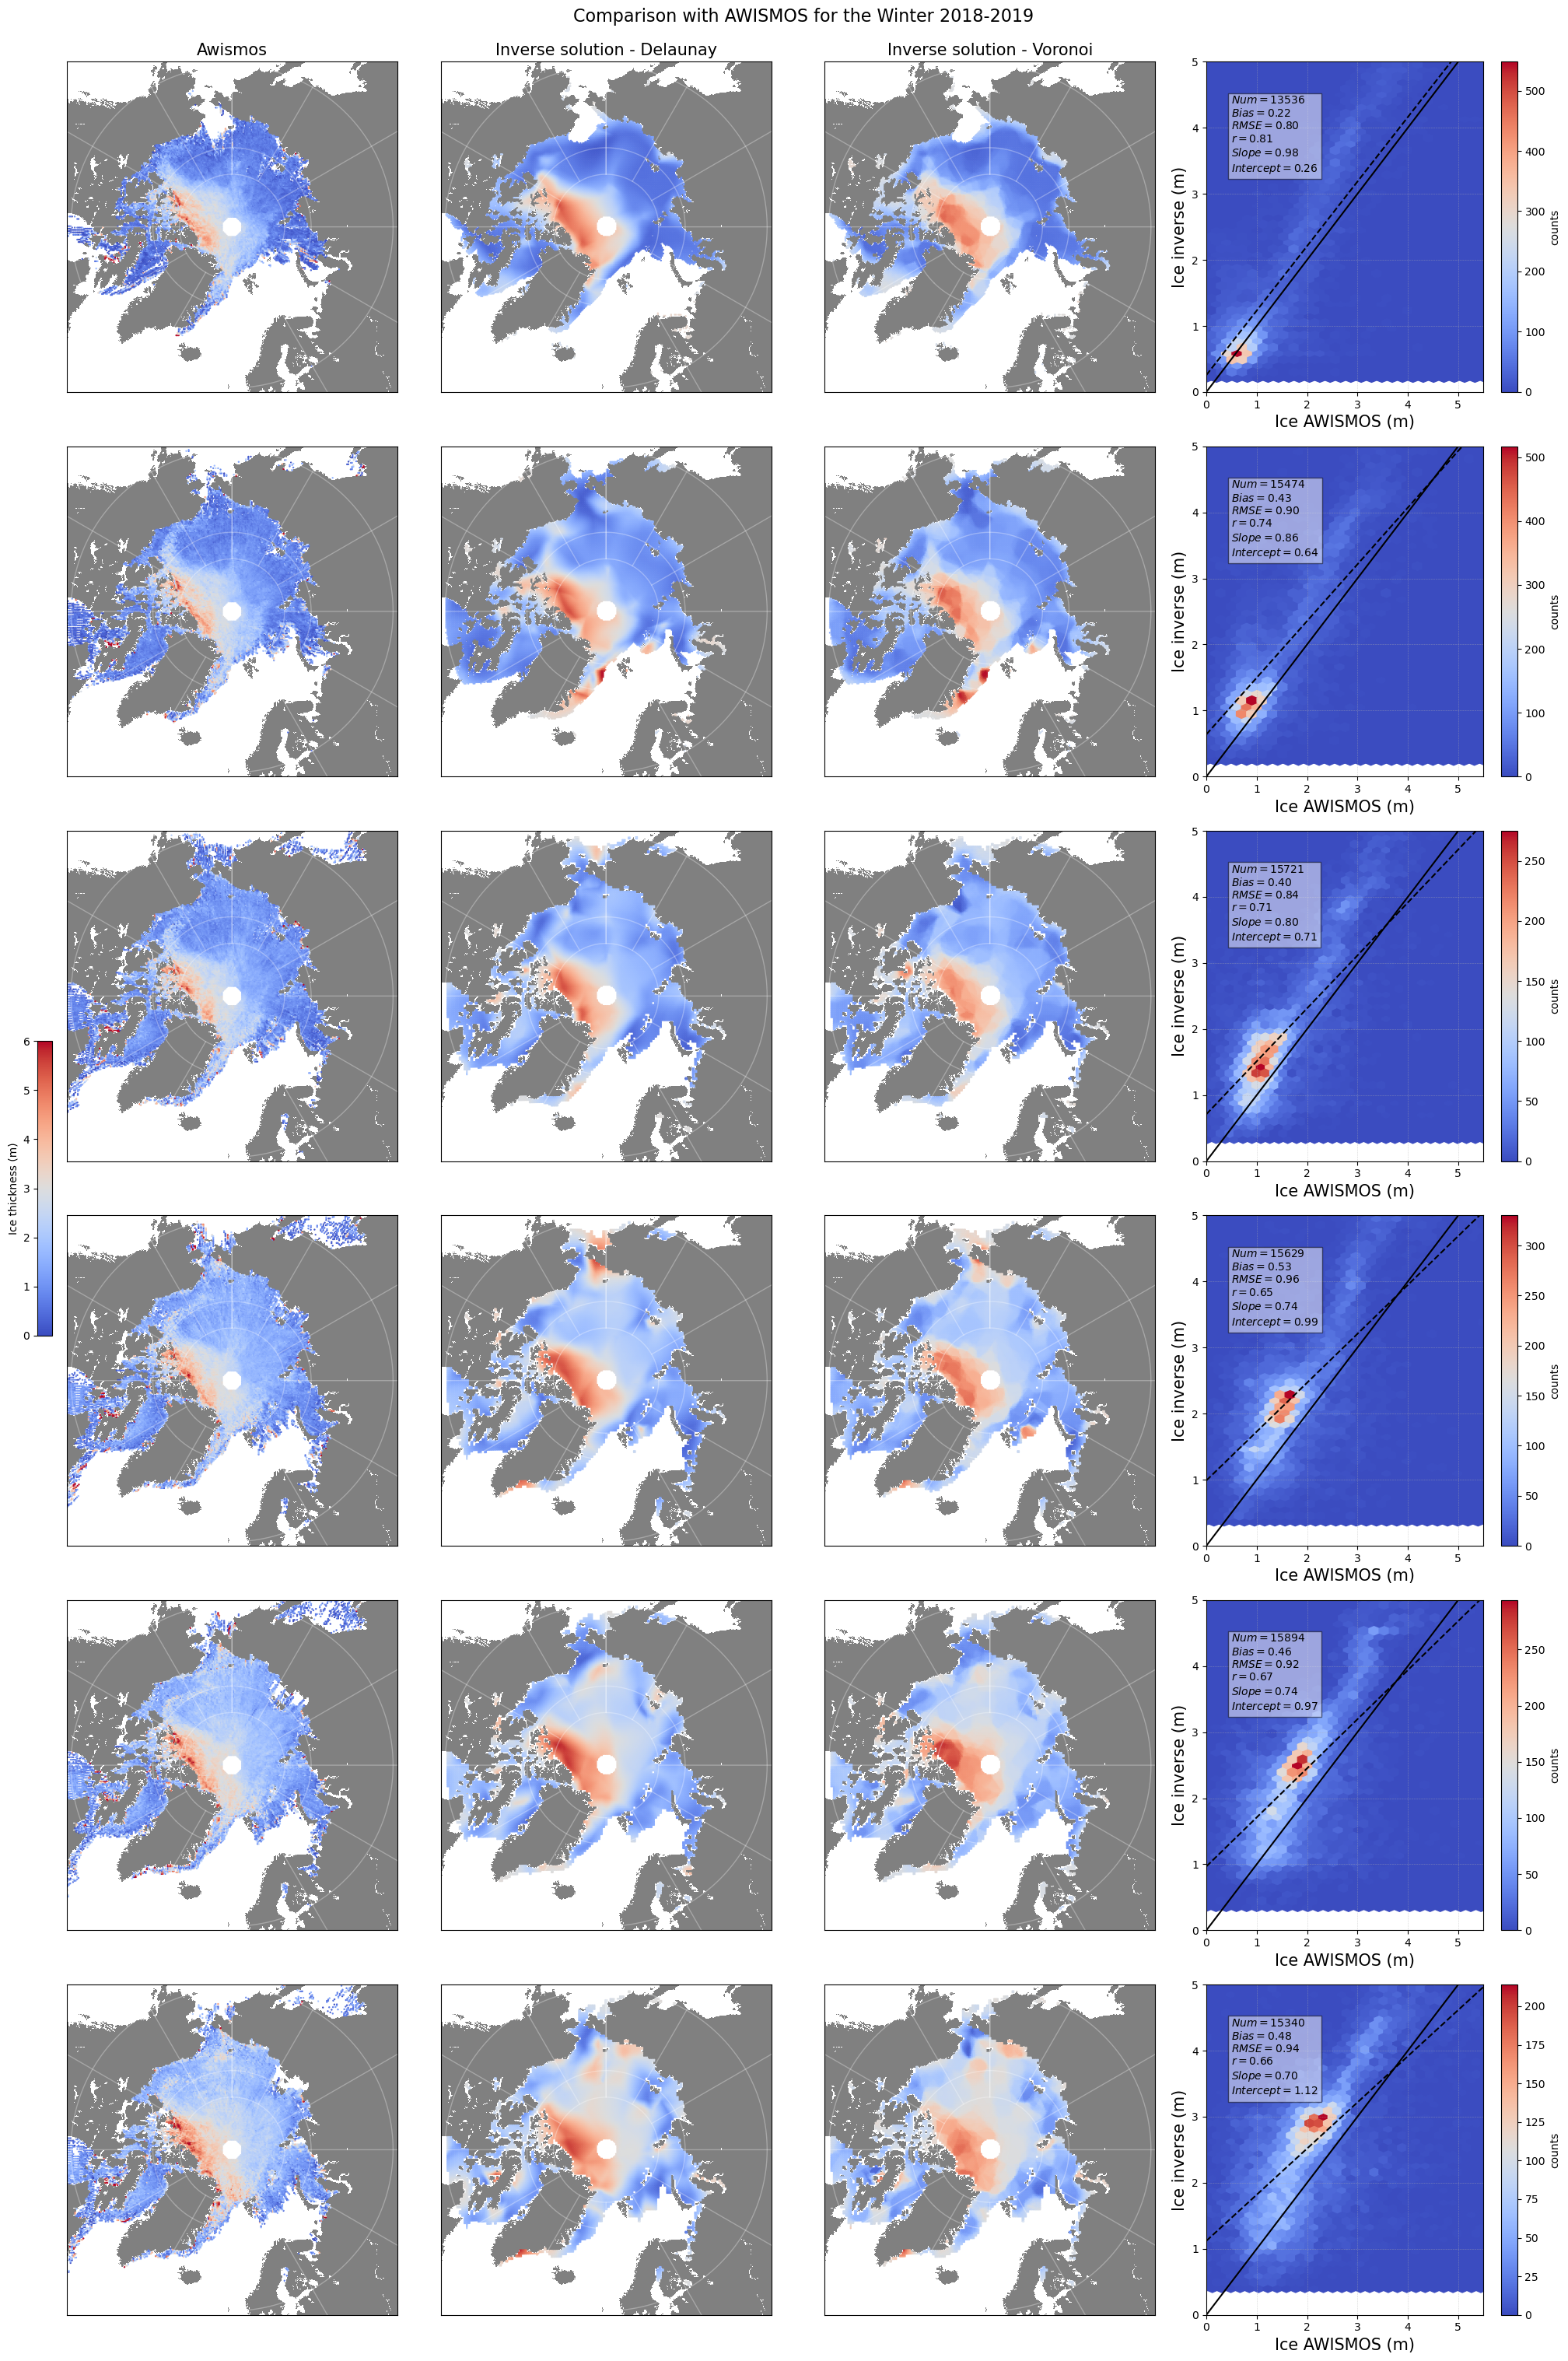

In [ ]:
fig, axs = plt.subplots(6, 4, figsize=(20, 30))
#plt.suptitle('Validation against AWISMOS for the Winter 2018-2019')

vmax, vmin = 6, 0


for i in range(6):
    if i == 0 :
        axs[i,0].set_title('Awismos', fontsize = 15)
    m1 = Basemap(ax=axs[i, 0],projection='lcc', resolution=None, lat_0=-90, lon_0=0, 
                lat_1=89.9, lon_1=180, width=0.7E7, height=0.7E7)
    draw_map(m1)
    sc = m1.scatter(lon_g, lat_g, latlon=True, alpha=1, s=0.5, c=ice_awismos(path_awismos[i]), 
                   cmap="coolwarm", vmin=vmin, vmax=vmax)

    if i == 0 :
        axs[i,1].set_title('Inverse solution - Delaunay', fontsize = 15)

    m2 = Basemap(ax=axs[i, 1], projection='lcc', resolution=None, lat_0=-90, lon_0=0, 
                lat_1=89.9, lon_1=180, width=0.7E7, height=0.7E7)
    draw_map(m2)
    sc = m2.scatter(lon_g, lat_g, latlon=True, alpha=1, s=0.5, c=np.load(inverse_delaunay_ice_files[i]), 
                   cmap="coolwarm", vmin=vmin, vmax=vmax)

    if i == 0 :
        axs[i,2].set_title('Inverse solution - Voronoi', fontsize = 15)

    m3 = Basemap(ax=axs[i, 2], projection='lcc', resolution=None, lat_0=-90, lon_0=0, 
                lat_1=89.9, lon_1=180, width=0.7E7, height=0.7E7)
    draw_map(m3)
    sc = m3.scatter(lon_g, lat_g, latlon=True, alpha=1, s=0.5, c=np.load(inverse_voronoi_ice_files[i]), 
                   cmap="coolwarm", vmin=vmin, vmax=vmax)

    ax3 = axs[i, 3]
    ice_inverse, SIT_awismos = inverse_ice(inverse_delaunay_ice_files[i], path_awismos[i])
    hb = ax3.hexbin(SIT_awismos, ice_inverse, gridsize=50, cmap='coolwarm')
    #ax3.scatter(SIT_awismos , ice_inverse, alpha = 0.5)
    ax3.set_xlabel('Ice AWISMOS (m)', fontsize = 15)
    ax3.set_ylabel('Ice inverse (m)', fontsize = 15)
    ax3.set_ylim(0, 5)
    ax3.set_xlim(0, 5.5)
    ax3.grid(linestyle='dotted', linewidth ='0.4')
    ax3.plot([0,5] , [0,5], 'k-')
    md_ice_inverse, rmse_ice_inverse, r2_ice_inverse, slope, intercept = analyse(ice_inverse, SIT_awismos)
    r_ice = pearson(SIT_awismos, ice_inverse)
    textstr = '\n'.join((
    rf'$Num = {len(ice_inverse)}$',
    rf'$Bias={md_ice_inverse:.2f}$',
    rf'$RMSE={rmse_ice_inverse:.2f}$',
    #rf'$R^2={r2_ice_inverse:.2f}$',
    rf'$r = {r_ice:.2f}$',
    rf'$Slope = {slope:.2f}$',
    rf'$Intercept = {intercept:.2f}$'))
    box_props = dict(boxstyle='square', facecolor= 'white', alpha=0.5)
    #ax3.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10,
    #     verticalalignment='top', bbox=box_props)
    ax3.text(0.5, 4.5, textstr, bbox=box_props, verticalalignment='top')
    x_values = np.array([0,5.5])
    y_values = slope * x_values + intercept
    ax3.plot(x_values, y_values, 'k--', label='Best fit')
    cb = fig.colorbar(hb, ax=ax3)
    cb.set_label('counts')




plt.tight_layout()
cbar = fig.colorbar(sc, ax=axs[:, :2], orientation='vertical', location = 'left',fraction=0.02, pad=0.02)
cbar.set_label('Ice thickness (m)')

fig.suptitle('Comparison with AWISMOS for the Winter 2018-2019', fontsize=16, y=1.01)

# Afficher le graphique
save_fig = 1 
if save_fig == 1: 
    plt.savefig('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/validation/comparison_awismos_2018-2019.png')

plt.show()


ValueError: 'c' argument has 1 elements, which is inconsistent with 'x' and 'y' with size 129600.

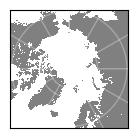

In [ ]:
import matplotlib.gridspec as gridspec

date = ['November', "December", "January", "February", "March", "April"]

fig = plt.figure(figsize=(15, 10))
spec = gridspec.GridSpec(ncols=2, nrows=6, hspace=0.1, wspace=0)

vmin = 0
vmax = 6

for i, ax in enumerate(spec):
    ax = plt.subplot(spec[i])
    m = Basemap(projection='lcc', resolution=None, lat_0=-90, lon_0=0, 
                lat_1=89.9, lon_1=180, width=0.7E7, height=0.7E7, ax=ax)
    draw_map(m)

    sc = m.scatter(lon_g, lat_g, latlon=True, alpha=1, s=0.5, c=SIT_awismos[i], 
                   cmap="coolwarm", vmin=vmin, vmax=vmax)
    ax.set_title(date[i])


cbar_ax = fig.add_axes([0.92, 0.136, 0.01, 0.735])
cbar = fig.colorbar(sc, cax=cbar_ax, extend='both')
cbar.ax.tick_params(labelsize=15)
cbar.set_label("Ice thickness (m)", fontsize=20, labelpad=10)


In [ ]:
is_files = ["/home/erb/masterproject/MSCI_project/snow_ice/carmen/daily_numpys/IS2/FB_interp_2019_25km_20191115.npy"]
cs_files = ["/home/erb/masterproject/MSCI_project/snow_ice/carmen/daily_numpys/CS2_LARM/FB_interp_2019-2020_25km_20191115.npy"]

inverse_ice_files = ['/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20191115_window+4j_ice.npy']

# grids
lon_g = np.load("/home/erb/masterproject/MSCI_project/new_lon_25km.npy")
lat_g = np.load("/home/erb/masterproject/MSCI_project/new_lat_25km.npy")

In [ ]:
ice_inverse =[]
ice_linear = []
ice_compare = []

DENSITY_WATER = 997.0
DENSITY_ICE = 917.0
DENSITY_SNOW = 300.0
SPEED_OF_LIGHT_VACUUM_OVER_SPEED_OF_LIGHT_SNOW = 1.28

A = (DENSITY_WATER - DENSITY_ICE) / DENSITY_WATER
B = 1 - SPEED_OF_LIGHT_VACUUM_OVER_SPEED_OF_LIGHT_SNOW -DENSITY_SNOW/DENSITY_WATER
D = 1 - DENSITY_SNOW/DENSITY_WATER

Hi = (A*np.load(cs_files[0]) - B*np.load(is_files[0]))/ A*(D-B)

ice_inverse_data = np.load(inverse_ice_files[0])
ice_inverse_data = mask_observations(Hi,ice_inverse_data)

for k in range(360):
    for j in range(360):
        #if not SIT_awismos.mask[k][j] and not np.isnan(ice_inverse_data[k][j]):
        if not np.isnan(ice_inverse_data[k][j]):
            ice_inverse.append(ice_inverse_data[k][j])
            ice_compare.append(SIT_awismos[k][j])
#            ice_linear.append(Hi[k][j])



Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


LinAlgError: SVD did not converge in Linear Least Squares

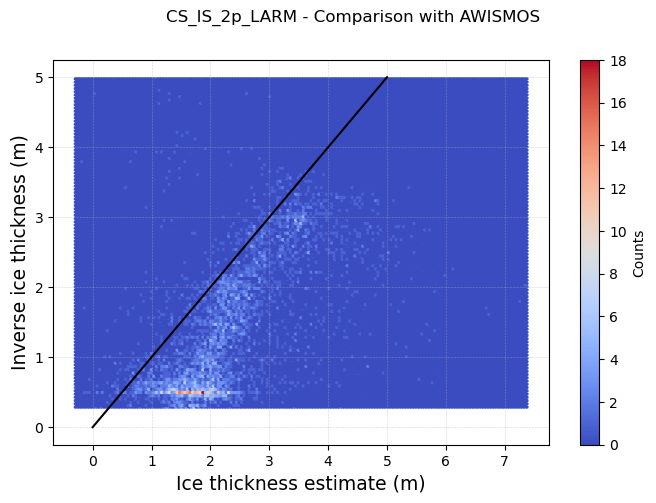

In [ ]:
fig = plt.figure(figsize=(8, 5))

plt.suptitle('CS_IS_2p_LARM - Comparison with AWISMOS')

#ax = fig.add_subplot(121)
#plt.scatter(ice_compare, ice_inverse, alpha = 0.5)
plt.hexbin(ice_compare, ice_inverse, gridsize=175, cmap='coolwarm')
plt.plot([0,5] , [0,5], 'k-', label = "One to one line")
plt.grid(linestyle='dotted', linewidth ='0.4')
#plt.xlim(0, 2.8)
#plt.ylim(0.3, 4.5)
plt.colorbar(label='Counts')
plt.xlabel('Ice thickness estimate (m)', fontsize = 13.5)
plt.ylabel('Inverse ice thickness (m)', fontsize = 13.5)


md_ice_inverse, rmse_ice_inverse, r2_ice_inverse, slope, intercept = analyse(ice_inverse, ice_compare)
r_ice = pearson(ice_compare, ice_inverse)

textstr = '\n'.join((
    rf'$Num = {len(ice_compare)}$',
    rf'$Bias={md_ice_inverse:.2f}$',
    rf'$RMSE={rmse_ice_inverse:.2f}$',
    #rf'$R^2={r2_ice_inverse:.2f}$',
    rf'$r = {r_ice:.2f}$',
    rf'$Slope = {slope:.2f}$',
    rf'$Intercept = {intercept:.2f}$'))
box_props = dict(boxstyle='square', facecolor= 'white', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=box_props)

# Regression line
x_values = np.array([0,7])
y_values = slope * x_values + intercept
plt.plot(x_values, y_values, 'k--', label='Best fit')

plt.legend(loc ='upper right')

ax = plt.gca()
ax.set_facecolor('lightgrey')

date = '11/2019'

if save_fig == 1 :
    plt.savefig('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/validation/non_interpolated/validation_AWISMOS' + year + '.png')


## Validation map

In [ ]:

laku_files = ["/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/validation_map/snow_201811_EASE2_laku_UIT.npy",
      "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/validation_map/snow_201812_EASE2_laku_UIT.npy",
      "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/validation_map/snow_201901_EASE2_laku_UIT.npy",
      "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/validation_map/snow_201902_EASE2_laku_UIT.npy",
      "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/validation_map/snow_201903_EASE2_laku_UIT.npy",
      "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/validation_map/snow_201904_EASE2_laku_UIT.npy"]

laku_UIT = []

lon_g = np.load("/home/erb/masterproject/MSCI_project/new_lon_25km.npy")
lat_g = np.load("/home/erb/masterproject/MSCI_project/new_lat_25km.npy")

for i in range(len(laku_files)):
    laku_UIT.append(np.load(laku_files[i]))

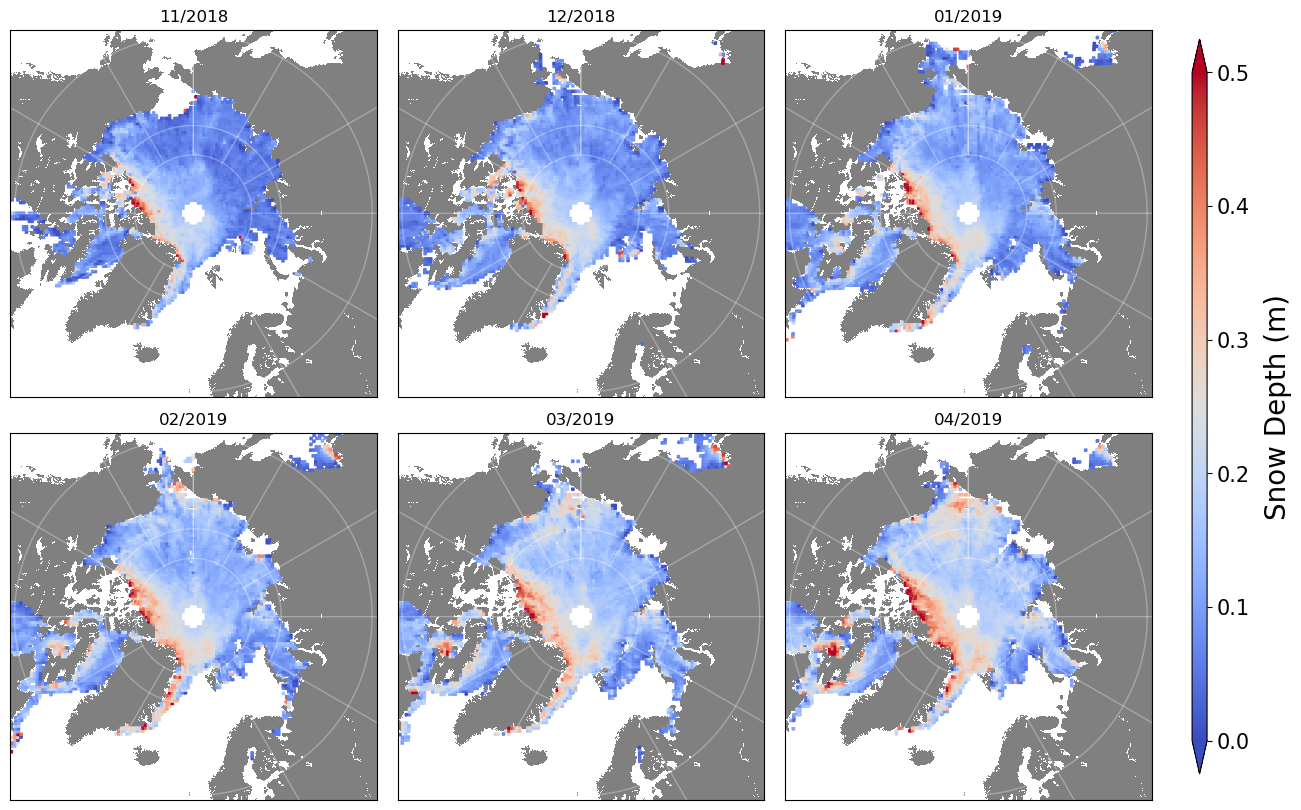

In [ ]:
import matplotlib.gridspec as gridspec

date = ['11/2018', '12/2018', '01/2019', '02/2019', '03/2019', '04/2019']

fig = plt.figure(figsize=(15, 10))
spec = gridspec.GridSpec(ncols=3, nrows=2, hspace=0.1, wspace=0)

vmin = 0
vmax = 0.5

for i, ax in enumerate(spec):
    ax = plt.subplot(spec[i])
    m = Basemap(projection='lcc', resolution=None, lat_0=-90, lon_0=0, 
                lat_1=89.9, lon_1=180, width=0.7E7, height=0.7E7, ax=ax)
    draw_map(m)

    sc = m.scatter(lon_g, lat_g, latlon=True, alpha=1, s=0.5, c=laku_UIT[i], 
                   cmap="coolwarm", vmin=vmin, vmax=vmax)
    ax.set_title(date[i])


cbar_ax = fig.add_axes([0.92, 0.136, 0.01, 0.735])
cbar = fig.colorbar(sc, cax=cbar_ax, extend='both')
cbar.ax.tick_params(labelsize=15)
cbar.set_label("Snow Depth (m)", fontsize=20, labelpad=10)


if save_fig == 1 :
    plt.savefig('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/validation/map_LAKU_UIT_2018-2019' + '.png')

plt.show()


In [ ]:
inverse_snow_files = ["/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20181115_window+-2j_error0.01_snow.npy",
                 "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20181215_window+-2j_error0.01_snow.npy", 
                 "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20190115_window+-2j_error0.01_snow.npy",
                 "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20190215_window+-2j_error0.01_snow.npy",
                 "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20190315_window+-2j_error0.01_snow.npy", 
                 "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20190415_window+-2j_error0.01_snow.npy"]

inverse_ice_file_2018to2022 = ["/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20181115_window+-2j_error0.01_ice.npy",
                 "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20181215_window+-2j_error0.01_ice.npy", 
                 "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20190115_window+-2j_error0.01_ice.npy",
                 "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20190215_window+-2j_error0.01_ice.npy",
                 "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20190315_window+-2j_error0.01_ice.npy", 
                 "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20190415_window+-2j_error0.01_ice.npy",
                 "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20191115_window+4j_ice.npy",
                 "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20191215_window+4j_ice.npy", 
                 "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20200115_window+4j_ice.npy",
                 "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20200215_window+4j_ice.npy",
                 "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20200315_window+4j_ice.npy", 
                 "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20200415_window+4j_ice.npy",
                 "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20201115_window+-2j_error0.05_ice.npy",
                 "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20201215_window+-2j_error0.05_ice.npy", 
                 "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20210115_window+-2j_error0.05_ice.npy",
                 "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20210215_window+-2j_error0.05_ice.npy",
                 "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20210315_window+-2j_error0.05_ice.npy", 
                 "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20210415_window+-2j_error0.05_ice.npy",
                 "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20211115_window5j_error0.05_ice.npy",
                 "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20211215_window5j_error0.05_ice.npy",
                 "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20220115_window5j_error0.05_ice.npy",
                 "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20220215_window5j_error0.05_ice.npy",
                 "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20220315_window5j_error0.05_ice.npy",
                 "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20220415_window5j_error0.05_ice.npy"]


inverse_ice_2018to2022 = []

for i in range(len(inverse_ice_file_2018to2022)):
    inverse_ice_2018to2022.append(np.load(inverse_ice_file_2018to2022[i]))


In [ ]:

lon_g = np.load("/home/erb/masterproject/MSCI_project/new_lon_25km.npy")
lat_g = np.load("/home/erb/masterproject/MSCI_project/new_lat_25km.npy")



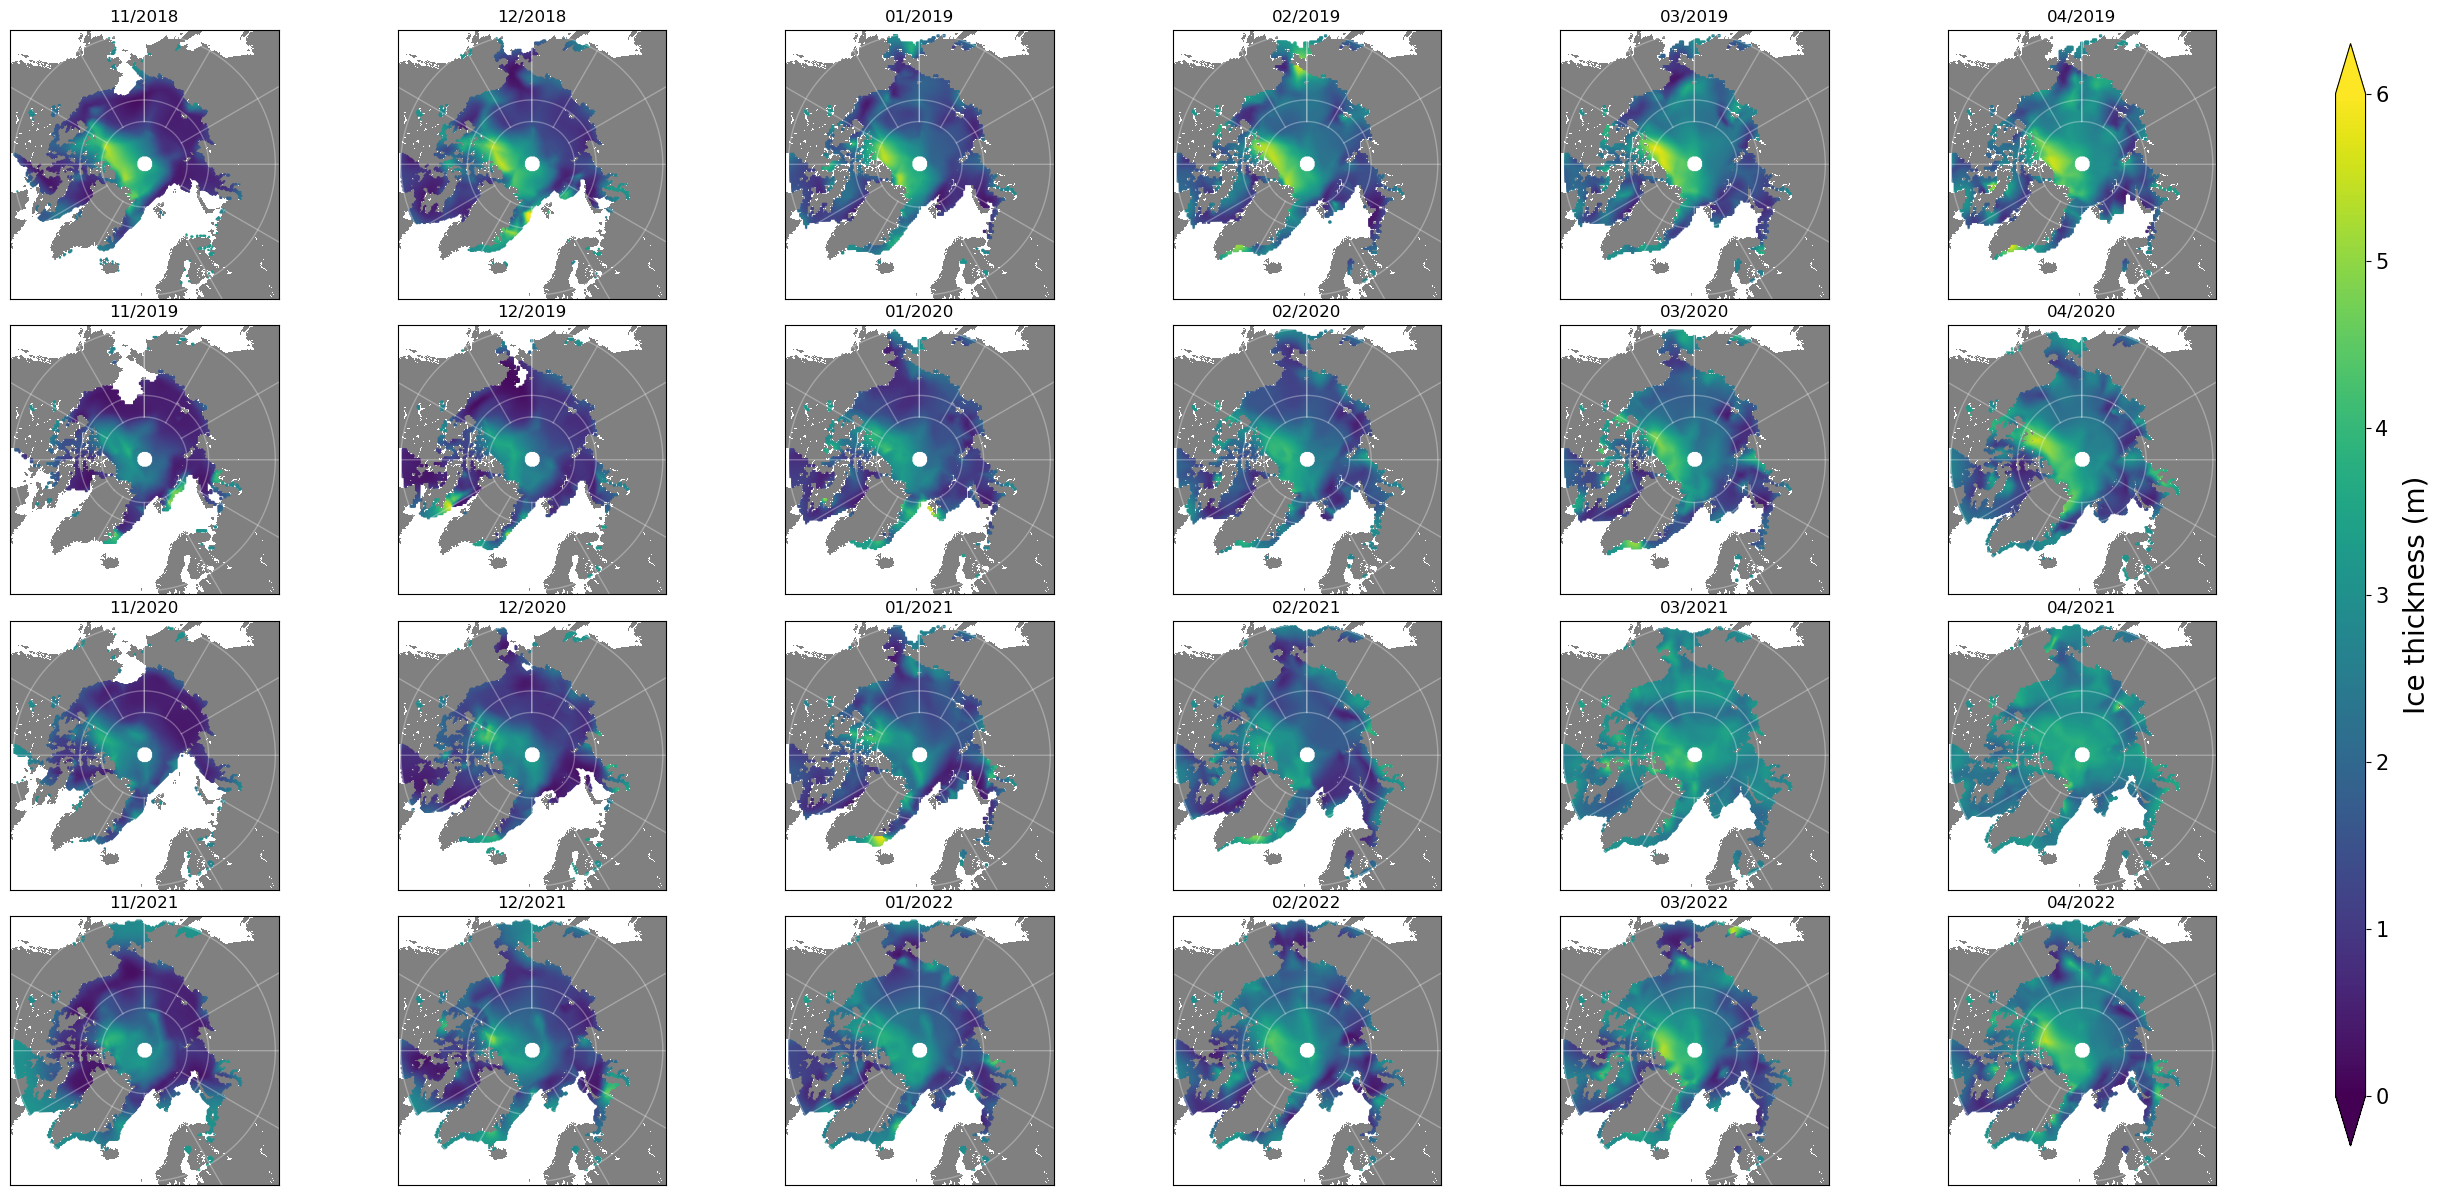

In [ ]:
import matplotlib.gridspec as gridspec


date = ['11/2018', '12/2018', '01/2019', '02/2019', '03/2019', '04/2019',
        '11/2019', '12/2019', '01/2020', '02/2020', '03/2020', '04/2020',
        '11/2020', '12/2020', '01/2021', '02/2021', '03/2021', '04/2021',
        '11/2021', '12/2021', '01/2022', '02/2022', '03/2022', '04/2022']

fig = plt.figure(figsize=(30, 15))
spec = gridspec.GridSpec(ncols=6, nrows=4, hspace=0.1, wspace=0)

vmin = 0
vmax = 6

for i, ax in enumerate(spec):
        ax = plt.subplot(spec[i])
        m = Basemap(projection='lcc', resolution=None, lat_0=-90, lon_0=0, 
                lat_1=89.9, lon_1=180, width=0.7E7, height=0.7E7, ax=ax)
        draw_map(m)
        sc = m.scatter(lon_g, lat_g, latlon=True, alpha=1, s=0.5, c=inverse_ice_2018to2022[i], 
                   cmap='viridis', vmin=vmin, vmax=vmax)
        ax.set_title(date[i])


cbar_ax = fig.add_axes([0.92, 0.136, 0.01, 0.735])
cbar = fig.colorbar(sc, cax=cbar_ax, extend='both')
cbar.ax.tick_params(labelsize=15)
cbar.set_label("Ice thickness (m)", fontsize=20, labelpad=10)


if save_fig == 1 :
    plt.savefig('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/validation/map_inverse_snow_2018-2019' + '.png')

plt.show()


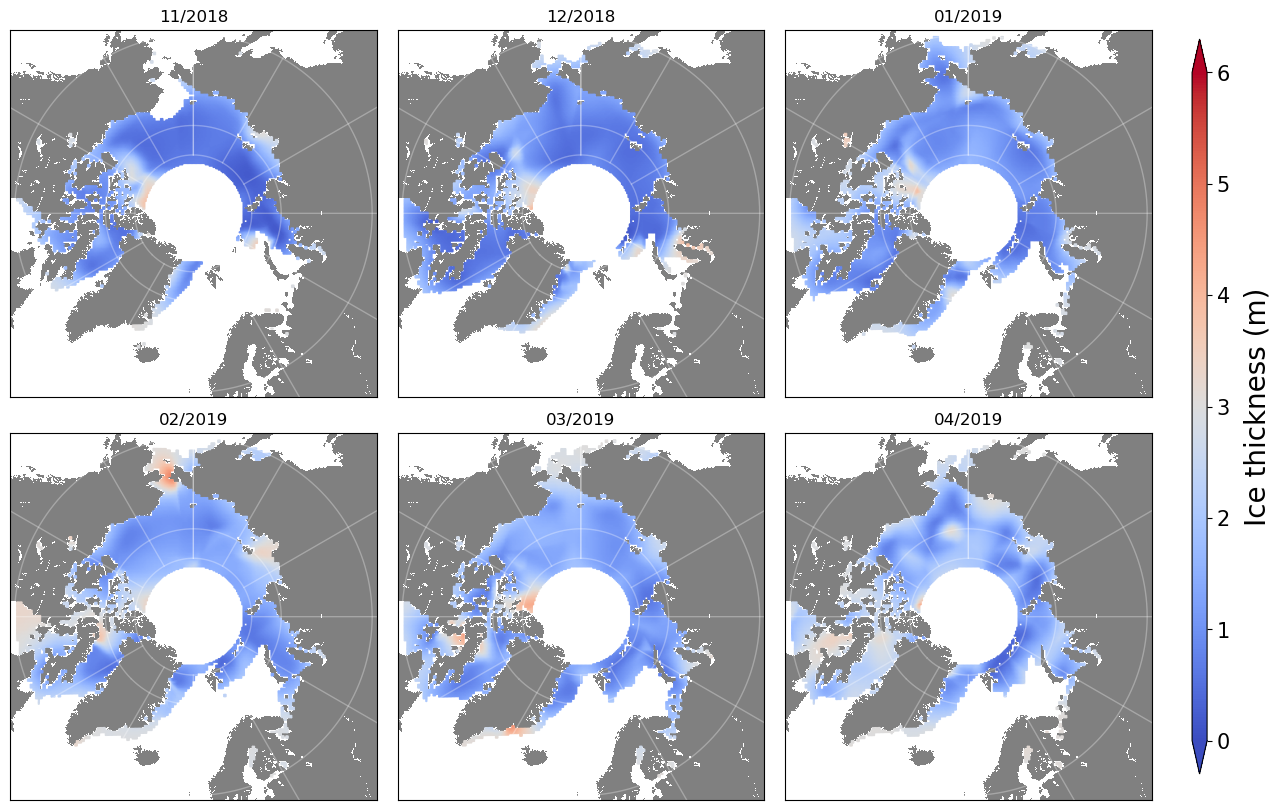

In [ ]:
import matplotlib.gridspec as gridspec

date = ['11/2018', '12/2018', '01/2019', '02/2019', '03/2019', '04/2019']

fig = plt.figure(figsize=(15, 10))
spec = gridspec.GridSpec(ncols=3, nrows=2, hspace=0.1, wspace=0)

vmin = 0
vmax = 6

for i, ax in enumerate(spec):
    ax = plt.subplot(spec[i])
    m = Basemap(projection='lcc', resolution=None, lat_0=-90, lon_0=0, 
                lat_1=89.9, lon_1=180, width=0.7E7, height=0.7E7, ax=ax)
    draw_map(m)

    sc = m.scatter(lon_g, lat_g, latlon=True, alpha=1, s=0.5, c=inverse_map_ice[i], 
                   cmap="coolwarm", vmin=vmin, vmax=vmax)
    ax.set_title(date[i])


cbar_ax = fig.add_axes([0.92, 0.136, 0.01, 0.735])
cbar = fig.colorbar(sc, cax=cbar_ax, extend='both')
cbar.ax.tick_params(labelsize=15)
cbar.set_label("Ice thickness (m)", fontsize=20, labelpad=10)


if save_fig == 1 :
    plt.savefig('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/validation/map_inverse_ice_2018-2019' + '.png')

plt.show()


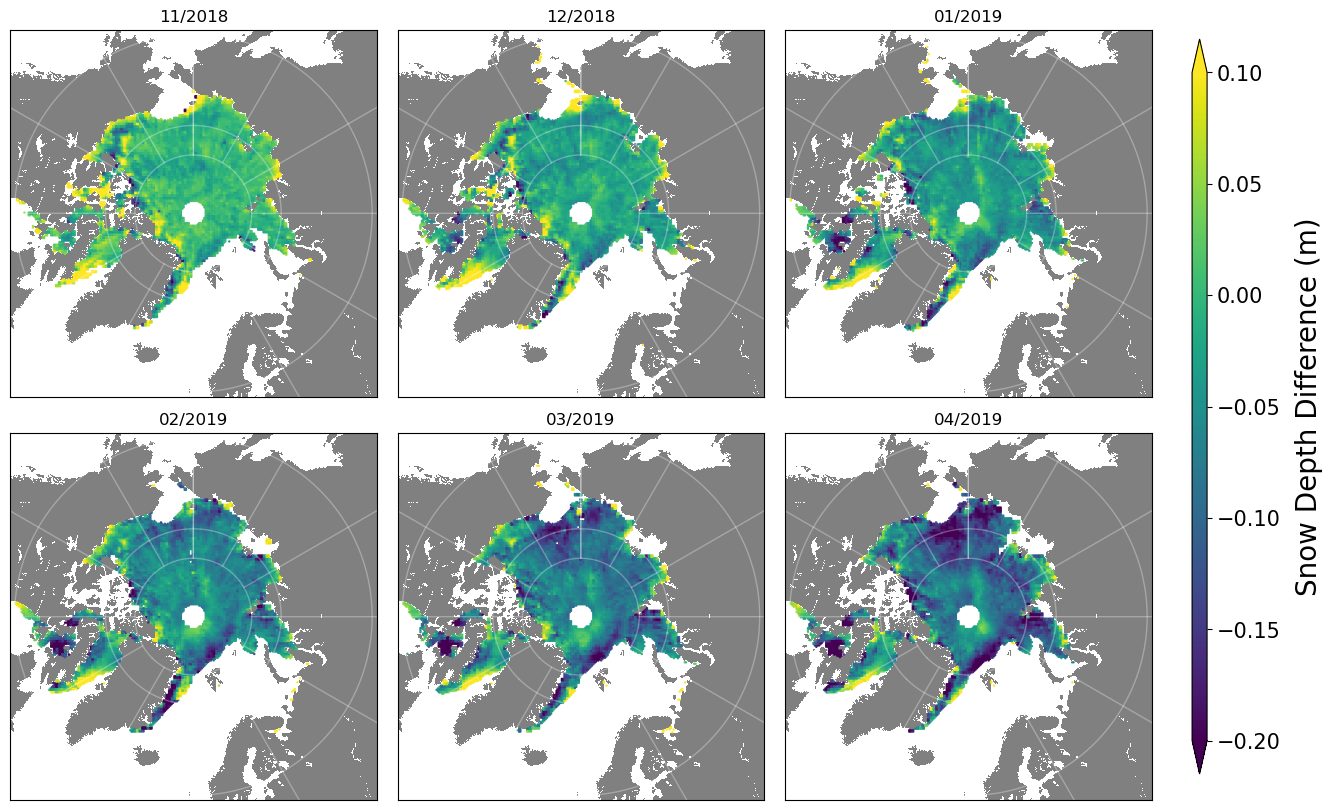

In [ ]:
import matplotlib.gridspec as gridspec

date = ['11/2018', '12/2018', '01/2019', '02/2019', '03/2019', '04/2019']

fig = plt.figure(figsize=(15, 10))
spec = gridspec.GridSpec(ncols=3, nrows=2, hspace=0.1, wspace=0)

vmin = -0.2
vmax = 0.1

for i, ax in enumerate(spec):
    ax = plt.subplot(spec[i])
    m = Basemap(projection='lcc', resolution=None, lat_0=-90, lon_0=0, 
                lat_1=89.9, lon_1=180, width=0.7E7, height=0.7E7, ax=ax)
    draw_map(m)

    sc = m.scatter(lon_g, lat_g, latlon=True, alpha=1, s=0.5, c=inverse_map_snow[i] - laku_UIT[i], 
                   cmap="viridis", vmin=vmin, vmax=vmax)
    ax.set_title(date[i])


cbar_ax = fig.add_axes([0.92, 0.136, 0.01, 0.735])
cbar = fig.colorbar(sc, cax=cbar_ax, extend='both')
cbar.ax.tick_params(labelsize=15)
cbar.set_label("Snow Depth Difference (m)", fontsize=20, labelpad=10)

if save_fig == 1:
    plt.savefig('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/validation/snow_difference2018-2019' + '.png')

plt.show()



In [ ]:
file_ice_winter_20182019 = ["/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20181115_window+-2j_error0.01_ice.npy",
                       "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20181215_window+-2j_error0.01_ice.npy", 
                       "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20190115_window+-2j_error0.01_ice.npy",
                       "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20190215_window+-2j_error0.01_ice.npy",
                       "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20190315_window+-2j_error0.01_ice.npy",
                       "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20190415_window+-2j_error0.01_ice.npy"]


file_ice_winter_20192020 = ["/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20191115_window+4j_ice.npy",
                       "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20191215_window+4j_ice.npy",
                       "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20200115_window+4j_ice.npy",
                       "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20200215_window+4j_ice.npy",
                       "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20200315_window+4j_ice.npy",
                       "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20200415_window+4j_ice.npy"]

file_ice_winter_20202021 = ["/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20201115_window+-2j_error0.05_ice.npy",
                       "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20201215_window+-2j_error0.05_ice.npy", 
                       "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20210115_window+-2j_error0.05_ice.npy",
                       "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20210215_window+-2j_error0.05_ice.npy",
                       "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20210315_window+-2j_error0.05_ice.npy",
                       "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20210415_window+-2j_error0.05_ice.npy"]




ice_20182019, ice_20192020, ice_20202021 = [], [], []

for i in range(len(file_ice_winter_20192020)):
    ice_20182019.append(np.load(file_ice_winter_20182019[i]))
    ice_20192020.append(np.load(file_ice_winter_20192020[i]))
    ice_20202021.append(np.load(file_ice_winter_20202021[i]))

for i in range(len(ice_20182019)):
    non_nan_indices = ~np.isnan(ice_20182019[i])
    ice_20182019[i] = ice_20182019[i][non_nan_indices]

    non_nan_indices = ~np.isnan(ice_20192020[i])
    ice_20192020[i] = ice_20192020[i][non_nan_indices]

    non_nan_indices = ~np.isnan(ice_20202021[i])
    ice_20202021[i] = ice_20202021[i][non_nan_indices]


for i in range(len(ice_20182019)):
    ice_20182019[i], ice_20192020[i], ice_20202021[i] = np.mean(ice_20182019[i]), np.mean(ice_20192020[i]), np.mean(ice_20202021[i])


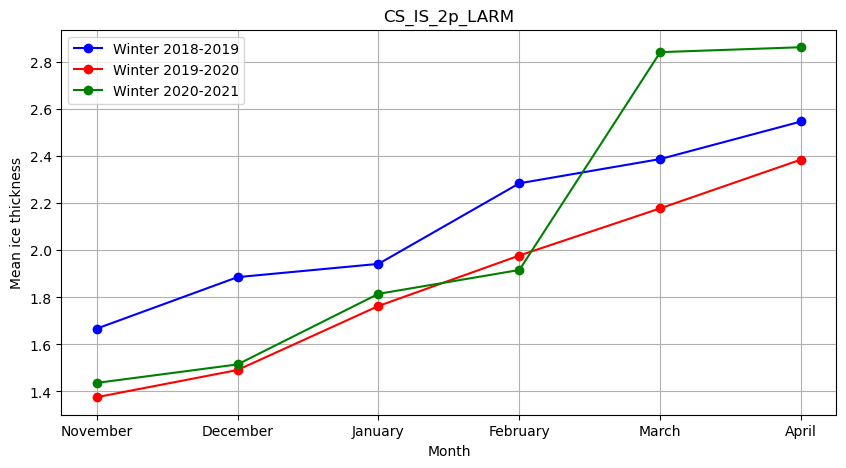

In [ ]:
date = ["November", "December", "January", "February", "March", "April"]


plt.figure(figsize=(10, 5))
plt.plot(date, ice_20182019, marker='o', linestyle='-', color='b', label = "Winter 2018-2019")
plt.plot(date, ice_20192020, marker='o', linestyle='-', color='r', label = "Winter 2019-2020")
plt.plot(date, ice_20202021, marker='o', linestyle='-', color='g', label = "Winter 2020-2021")

plt.title("CS_IS_2p_LARM")
plt.xlabel("Month")
plt.ylabel("Mean ice thickness")
plt.legend()

plt.grid(True)
plt.show()


In [ ]:
file_snow_winter_20182019 = ["/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20181115_window+-2j_error0.01_snow.npy",
                       "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20181215_window+-2j_error0.01_snow.npy", 
                       "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20190115_window+-2j_error0.01_snow.npy",
                       "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20190215_window+-2j_error0.01_snow.npy",
                       "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20190315_window+-2j_error0.01_snow.npy",
                       "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20190415_window+-2j_error0.01_snow.npy"]


file_snow_winter_20192020 = ["/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20191115_window+4j_snow.npy",
                       "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20191215_window+4j_snow.npy",
                       "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20200115_window+4j_snow.npy",
                       "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20200215_window+4j_snow.npy",
                       "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20200315_window+4j_snow.npy",
                       "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20200415_window+4j_snow.npy"]

file_snow_winter_20202021 = ["/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20201115_window+-2j_error0.05_snow.npy",
                       "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20201215_window+-2j_error0.05_snow.npy", 
                       "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20210115_window+-2j_error0.05_snow.npy",
                       "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20210215_window+-2j_error0.05_snow.npy",
                       "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20210315_window+-2j_error0.05_snow.npy",
                       "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20210415_window+-2j_error0.05_snow.npy"]




snow_20182019, snow_20192020, snow_20202021 = [], [], []

for i in range(len(file_snow_winter_20192020)):
    snow_20182019.append(np.load(file_snow_winter_20182019[i]))
    snow_20192020.append(np.load(file_snow_winter_20192020[i]))
    snow_20202021.append(np.load(file_snow_winter_20202021[i]))

for i in range(len(snow_20182019)):
    non_nan_indices = ~np.isnan(snow_20182019[i])
    snow_20182019[i] = snow_20182019[i][non_nan_indices]

    non_nan_indices = ~np.isnan(snow_20192020[i])
    snow_20192020[i] = snow_20192020[i][non_nan_indices]

    non_nan_indices = ~np.isnan(snow_20202021[i])
    snow_20202021[i] = snow_20202021[i][non_nan_indices]


for i in range(len(snow_20182019)):
    snow_20182019[i], snow_20192020[i], snow_20202021[i] = np.mean(snow_20182019[i]), np.mean(snow_20192020[i]), np.mean(snow_20202021[i])


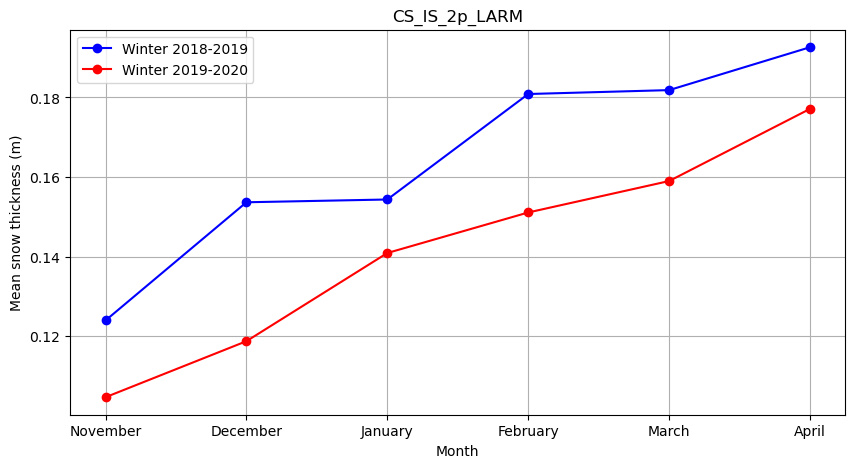

In [ ]:
date = ["November", "December", "January", "February", "March", "April"]


plt.figure(figsize=(10, 5))
plt.plot(date, snow_20182019, marker='o', linestyle='-', color='b', label = "Winter 2018-2019")
plt.plot(date, snow_20192020, marker='o', linestyle='-', color='r', label = "Winter 2019-2020")
#plt.plot(date, snow_20202021, marker='o', linestyle='-', color='g', label = "Winter 2020-2021")

plt.title("CS_IS_2p_LARM")
plt.xlabel("Month")
plt.ylabel("Mean snow thickness (m)")
plt.legend()

plt.grid(True)
plt.show()


In [ ]:
ice_2021 = np.load('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20210415_window+-2j_error0.05_ice.npy')

In [ ]:

non_nan_indices = ~np.isnan(ice_2021)
ice_2021 = ice_2021[non_nan_indices]

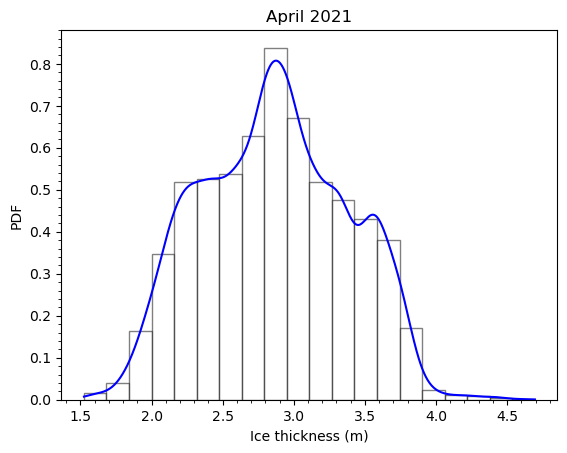

In [ ]:
from scipy.stats import gaussian_kde

plt.title('April 2021')
kde = gaussian_kde(ice_2021, bw_method='scott')
x_range = np.linspace(ice_2021.min(), ice_2021.max(), 1000)
kde_values = kde(x_range)
plt.hist(ice_2021, bins=20, density=True, alpha=0.5, color='white', edgecolor='black')
plt.plot(x_range, kde_values, color='blue')
plt.ylabel('PDF')
plt.xlabel('Ice thickness (m)')
plt.minorticks_on()

